In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import LabelEncoder # Kept for potential future use
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings

In [2]:
# Suppress all warnings for cleaner output
warnings.filterwarnings("ignore")

# --- Configuration ---
TARGET_COLUMNS = [
    "depression_level",
    "life_satisfication_level",
    "Big_five_personality_level"
]
TEST_SIZE = 0.2
RANDOM_STATE = 42

# --- Helper Functions for Plotting (plot_confusion_matrix_display, plot_model_performance_metrics, plot_decision_boundary) ---
# These functions remain unchanged from your provided code.

def plot_confusion_matrix_display(model, X_test, y_test, title):
    """
    Plots the confusion matrix for a given model.
    Note: This function uses ConfusionMatrixDisplay which needs to be imported directly.
    """
    from sklearn.metrics import ConfusionMatrixDisplay
    try:
        # For some models (like pipelines or stacked models), classes_ might not be directly available
        # or X_test might be transformed (e.g. SVM features for hybrid model)
        # We predict first to ensure compatibility and then get classes if needed
        y_pred = model.predict(X_test)
        labels = model.classes_ if hasattr(model, 'classes_') else np.unique(y_test)

        fig, ax = plt.subplots(figsize=(6, 5))
        ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred,
            display_labels=labels,
            cmap=plt.cm.Blues,
            ax=ax
        )
        ax.set_title(title)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting confusion matrix for {title}: {e}")

def plot_model_performance_metrics(y_true, y_pred, y_prob, title):
    """
    Plots confusion matrix, ROC curve, and key performance metrics (Accuracy, Precision, Recall, F1-Score).
    This function is designed to be comprehensive for model evaluation.
    """
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title(f"Confusion Matrix\n{title}")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Actual")

    # ROC Curve
    num_classes = len(set(y_true))
    if num_classes == 2: # Binary classification
        if y_prob is not None:
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc_val = auc(fpr, tpr)
            axs[1].plot(fpr, tpr, label=f"AUC = {roc_auc_val:.2f}")
            axs[1].plot([0, 1], [0, 1], 'k--')
            axs[1].set_title(f"ROC Curve\n{title}")
            axs[1].set_xlabel("False Positive Rate")
            axs[1].set_ylabel("True Positive Rate")
            axs[1].legend(loc='lower right')
        else:
            axs[1].set_title(f"ROC Curve\n{title} (Skipped - No probabilities)")
            axs[1].text(0.5, 0.5, 'Probabilities not available', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
    else: # Multiclass classification
        axs[1].set_title(f"ROC Curve\n{title} (Multiclass)")
        # Note: For multiclass, ROC AUC is often calculated one-vs-rest or one-vs-one.
        # Here we'll just display the ROC-AUC score passed or calculated if available.
        # The y_prob for roc_auc_score in multiclass should be probabilities for each class.
        try:
            # This assumes y_prob contains probabilities for roc_auc_score later
            # For plotting, a simple message is shown as multiclass ROC plotting is more complex.
            roc_auc_val = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted') if y_prob is not None else np.nan
            axs[1].text(0.5, 0.5, f'Multiclass ROC AUC: {roc_auc_val:.2f}\n(Plotting requires OvR/OvO approach)',
                        horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)
        except ValueError as e:
             axs[1].text(0.5, 0.5, f'ROC AUC not available\nor error: {e}',
                        horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes)


    # Metrics Bar Chart
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_true, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }
    axs[2].bar(metrics.keys(), metrics.values(), color='skyblue')
    axs[2].set_ylim(0, 1)
    axs[2].set_title(f"Performance Metrics\n{title}")
    axs[2].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

def plot_decision_boundary(model, X, y, title):
    """
    Helper function to plot decision boundaries.
    It expects X to have exactly two features for 2D plotting.
    The model should be pre-trained.
    """
    if X.shape[1] != 2:
        print(f"Skipping decision boundary plot for '{title}': Requires exactly 2 features for X, but found {X.shape[1]}.")
        return

    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
        # Create a DataFrame from meshgrid for prediction, matching feature names if X is a DataFrame
    mesh_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=X.columns[:2])


    if hasattr(model, "predict_proba"):
        # For multiclass, predict_proba returns (n_samples, n_classes).
        # We need to decide how to color: probability of a specific class or max probability.
        # For simplicity, if multiclass, we take prob of class 1 if it exists, else class 0, or just use predict.
        probas = model.predict_proba(mesh_data)
        if probas.shape[1] > 1:
            Z = probas[:, 1] # Probability of the second class (often class '1')
        else: # Should not happen if predict_proba exists and multiple classes
            Z = probas[:, 0]
    elif hasattr(model, "decision_function"): # e.g. SVM
        Z = model.decision_function(mesh_data)
        if len(Z.shape) > 1 and Z.shape[1] > 1: # Multiclass SVM decision_function
             Z = Z[:, 1] # Or handle as max of decision_function values
        Z = (Z - Z.min()) / (Z.max() - Z.min()) # Scale for consistent color mapping
    else: # Fallback to direct prediction
        Z = model.predict(mesh_data)
        # If Z is multiclass, we might need to map it to a single dimension for contourf
        # For simplicity, this example assumes Z can be directly used or is binary.

    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    contour = plt.contourf(xx, yy, Z, cmap='RdBu', alpha=0.8, levels=np.linspace(Z.min(), Z.max(), 11))
    plt.colorbar(contour, label='Predicted Probability / Decision Value / Class')

    # Scatter plot of actual data points (use the passed X and y)
    # Ensure y is numeric for coloring
    y_numeric = pd.Series(y).astype('category').cat.codes
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_numeric, cmap='RdBu', edgecolor='k', s=50, alpha=0.8)
    plt.title(title)
    plt.xlabel(X.columns[0] if isinstance(X, pd.DataFrame) else "Feature 1")
    plt.ylabel(X.columns[1] if isinstance(X, pd.DataFrame) else "Feature 2")
    plt.show()


In [3]:
# --- Section 1: Synthetic Data Generation (Gaussian Noise Addition) ---
# Unchanged
def generate_and_save_synthetic_data(file_path='processed_data.csv', n_samples=5269):
    """
    Generates synthetic data by adding Gaussian noise to existing data points.
    """
    print("\n--- Step 1: Synthetic Data Generation (Gaussian Noise Addition) ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found. Please ensure it exists in the current directory.")
        print("Skipping synthetic data generation and subsequent steps that depend on it.")
        return None # Return None to indicate failure


    # Keep only numeric columns
    df_numeric = df.select_dtypes(include=['number'])
    if df_numeric.empty:
        print("Error: No numeric columns found in the input file for synthetic data generation.")
        return None


    synthetic_data = pd.DataFrame()

    for _ in range(n_samples):
        noise = np.random.normal(loc=0, scale=0.1, size=df_numeric.shape[1])
        synthetic_row = df_numeric.sample(1, replace=True).values.flatten() + noise
        synthetic_data = pd.concat([synthetic_data, pd.DataFrame([synthetic_row], columns=df_numeric.columns)], ignore_index=True)

    synthetic_data = synthetic_data.round().clip(lower=df_numeric.min(), upper=df_numeric.max(), axis=1)

    output_filename = "synthetic_data_gna_5269.csv"
    synthetic_data.to_csv(output_filename, index=False)
    print(f"✅ Synthetic data generated using Gaussian Noise Addition and saved as '{output_filename}'")
    return synthetic_data

In [4]:
# --- Section 2: Data Cleaning for Synthetic Data ---
# Unchanged
def clean_and_save_synthetic_data(synthetic_data):
    """
    Cleans the generated synthetic dataset by removing duplicates and imputing missing values.
    """
    if synthetic_data is None:
        print("Skipping data cleaning as synthetic data was not generated.")
        return None
    print("\n--- Step 2: Data Cleaning for Synthetic Data ---")
    synthetic_df = synthetic_data.copy()

    num_columns = synthetic_df.select_dtypes(include=np.number).columns.tolist()
    # Assuming GNA produces only numeric, but good to have a placeholder
    cat_columns = synthetic_df.select_dtypes(exclude=np.number).columns.tolist()


    synthetic_df = synthetic_df.drop_duplicates()

    for col in num_columns:
        if col in synthetic_df.columns: # Check if column still exists
            synthetic_df[col].fillna(synthetic_df[col].mean(), inplace=True)

    for col in cat_columns: # This loop might not run if GNA data is all numeric
         if col in synthetic_df.columns:
            synthetic_df[col].fillna(synthetic_df[col].mode()[0], inplace=True)

    output_filename = "synthetic_data_gna_cleaned.csv"
    synthetic_df.to_csv(output_filename, index=False)
    print(f"✅ Cleaned synthetic dataset generated and saved as '{output_filename}'")
    return synthetic_df

In [5]:
# --- Section 3: Data Preprocessing and Balancing (SMOTE) ---
# Unchanged
def preprocess_and_balance_data(data_path, target_columns):
    """
    Performs data cleaning, imputation, encoding, and SMOTE balancing for each target variable.
    """
    print("\n--- Step 3: Data Preprocessing and Balancing (SMOTE) ---")
    try:
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"Error: Cleaned synthetic data file '{data_path}' not found. Skipping preprocessing.")
        return False # Indicate failure


    df.columns = [col.split("\n")[0].strip() for col in df.columns]

    num_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_columns = df.select_dtypes(include=['object']).columns.tolist()

    if num_columns:
        num_imputer = SimpleImputer(strategy="mean")
        df[num_columns] = num_imputer.fit_transform(df[num_columns])

    if cat_columns:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        df[cat_columns] = cat_imputer.fit_transform(df[cat_columns])
        df_encoded = pd.get_dummies(df, columns=cat_columns, drop_first=True)
    else:
        df_encoded = df.copy()


    for target_col in target_columns:
        print(f"\nProcessing Target: {target_col}")

        if target_col not in df_encoded.columns:
            print(f"  Target column '{target_col}' not found after encoding/cleaning. Skipping SMOTE for this target.")
            continue

        X = df_encoded.drop(columns=[target_col] + [tc for tc in target_columns if tc != target_col and tc in df_encoded.columns])
        y = df_encoded[target_col]

        # Ensure y is integer type for SMOTE if it's not already
        if not pd.api.types.is_integer_dtype(y):
            try:
                y = y.astype(int)
                print(f"  Converted target '{target_col}' to integer type for SMOTE.")
            except ValueError:
                print(f"  Could not convert target '{target_col}' to integer. SMOTE may fail. Trying LabelEncoder.")
                le = LabelEncoder()
                y = le.fit_transform(y)


        # Convert continuous to binary/multiclass if necessary (example: median split for binary)
        if y.dtype in ['float64'] or (pd.api.types.is_integer_dtype(y) and len(y.unique()) > 10): # Heuristic for "continuous-like"
            median_val = y.median()
            y_original_type = y.dtype
            y = (y >= median_val).astype(int) # Binary classification
            print(f"  Converted continuous-like target '{target_col}' to binary (0/1) based on median split for SMOTE.")


        print("  Original distribution:")
        print(y.value_counts())

        if len(y.value_counts()) < 2 or y.value_counts().min() < 6 : # SMOTE needs k_neighbors < n_samples_in_smallest_class
            print(f"  SMOTE cannot be applied for target '{target_col}' due to insufficient samples in minority class or only one class present. Skipping balancing.")
            X_resampled, y_resampled = X.copy(), y.copy()
        else:
            try:
                # Adjust k_neighbors if minority class is too small
                minority_class_count = y.value_counts().min()
                k_neighbors = min(5, minority_class_count - 1) if minority_class_count > 1 else 1

                if k_neighbors < 1: # Should be caught by the check above, but as a safeguard
                    print(f"  Cannot apply SMOTE for target '{target_col}', k_neighbors would be < 1. Skipping balancing.")
                    X_resampled, y_resampled = X.copy(), y.copy()
                else:
                    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
                    X_resampled, y_resampled = smote.fit_resample(X, y)
            except Exception as e:
                print(f"  SMOTE failed for target '{target_col}': {e}. Using original data for this target.")
                X_resampled, y_resampled = X.copy(), y.copy()


        print("  After SMOTE (or original if SMOTE failed/skipped):")
        print(pd.Series(y_resampled).value_counts())

        balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
        balanced_df[target_col] = y_resampled
        output_path = f"balanced_dataset_{target_col}.csv"
        balanced_df.to_csv(output_path, index=False)
        print(f"  Balanced (or original) dataset saved to: {output_path}")

        plt.figure(figsize=(5, 3))
        sns.barplot(x=pd.Series(y_resampled).value_counts().index.astype(str),
                    y=pd.Series(y_resampled).value_counts().values)
        plt.title(f"Class Distribution for {target_col} (After SMOTE/Processing)")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()
    return True # Indicate success


--- Starting the ML Pipeline ---

--- Step 1: Synthetic Data Generation (Gaussian Noise Addition) ---
✅ Synthetic data generated using Gaussian Noise Addition and saved as 'synthetic_data_gna_5269.csv'

--- Step 2: Data Cleaning for Synthetic Data ---
✅ Cleaned synthetic dataset generated and saved as 'synthetic_data_gna_cleaned.csv'

--- Step 3: Data Preprocessing and Balancing (SMOTE) ---

Processing Target: depression_level
  Converted target 'depression_level' to integer type for SMOTE.
  Converted continuous-like target 'depression_level' to binary (0/1) based on median split for SMOTE.
  Original distribution:
depression_level
1    95
0    94
Name: count, dtype: int64
  After SMOTE (or original if SMOTE failed/skipped):
depression_level
1    95
0    95
Name: count, dtype: int64
  Balanced (or original) dataset saved to: balanced_dataset_depression_level.csv


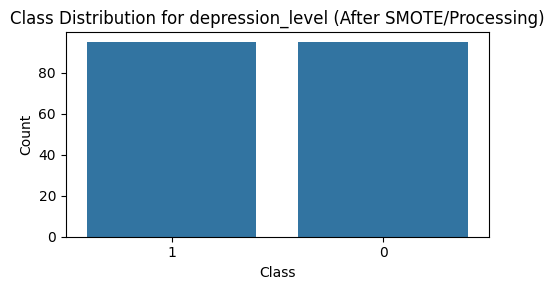


Processing Target: life_satisfication_level
  Converted target 'life_satisfication_level' to integer type for SMOTE.
  Converted continuous-like target 'life_satisfication_level' to binary (0/1) based on median split for SMOTE.
  Original distribution:
life_satisfication_level
1    102
0     87
Name: count, dtype: int64
  After SMOTE (or original if SMOTE failed/skipped):
life_satisfication_level
0    102
1    102
Name: count, dtype: int64
  Balanced (or original) dataset saved to: balanced_dataset_life_satisfication_level.csv


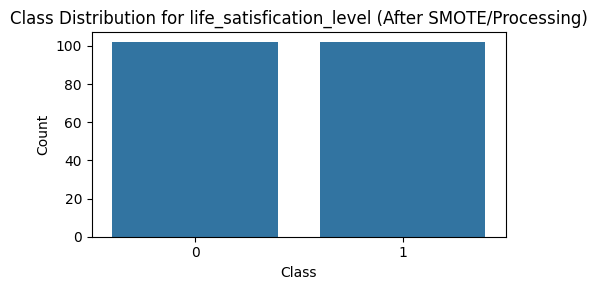


Processing Target: Big_five_personality_level
  Converted target 'Big_five_personality_level' to integer type for SMOTE.
  Converted continuous-like target 'Big_five_personality_level' to binary (0/1) based on median split for SMOTE.
  Original distribution:
Big_five_personality_level
1    102
0     87
Name: count, dtype: int64
  After SMOTE (or original if SMOTE failed/skipped):
Big_five_personality_level
0    102
1    102
Name: count, dtype: int64
  Balanced (or original) dataset saved to: balanced_dataset_Big_five_personality_level.csv


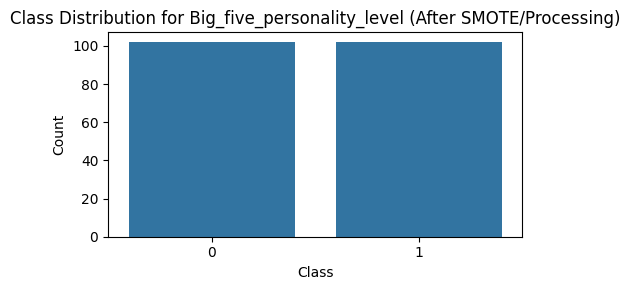



==================== Target Variable: depression_level ====================

--- Training All Models ---
  Training Individual Models...
    Successfully trained Logistic Regression.
    Successfully trained Decision Tree.
    Successfully trained SVM.
    Successfully trained Gaussian NB.
    Successfully trained Random Forest.
    Successfully trained Gradient Boosting.
    Successfully trained XGBoost.
  Training Stacking Models...
    Successfully trained Stack 1.
    Successfully trained Stack 2.
  Training Hybrid SVM + XGBoost Model...
    Successfully trained Hybrid SVM+XGBoost.


--- Comprehensive Evaluation & Plotting for Target: depression_level ---

▶ Evaluating Model: Logistic Regression
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.76      1.00      0.86        19

    accuracy                           0.84        38
   macro avg       0.88      0.84      0.84   

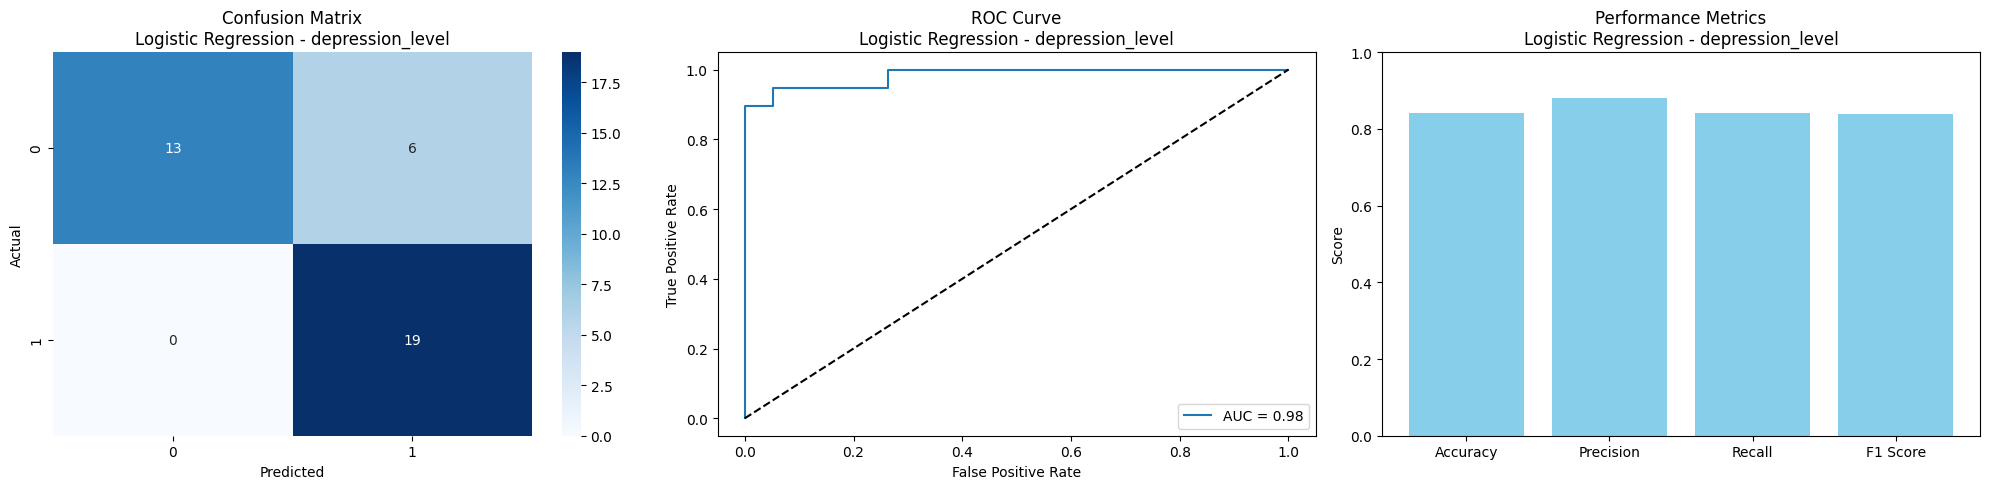

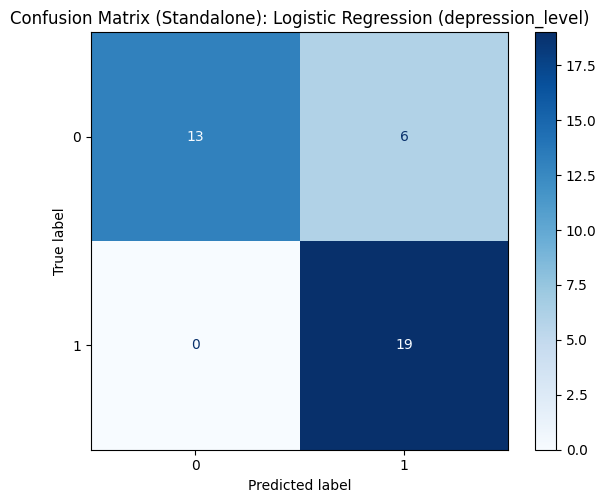


▶ Evaluating Model: Decision Tree
  Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.76      0.84      0.80        19

    accuracy                           0.79        38
   macro avg       0.79      0.79      0.79        38
weighted avg       0.79      0.79      0.79        38



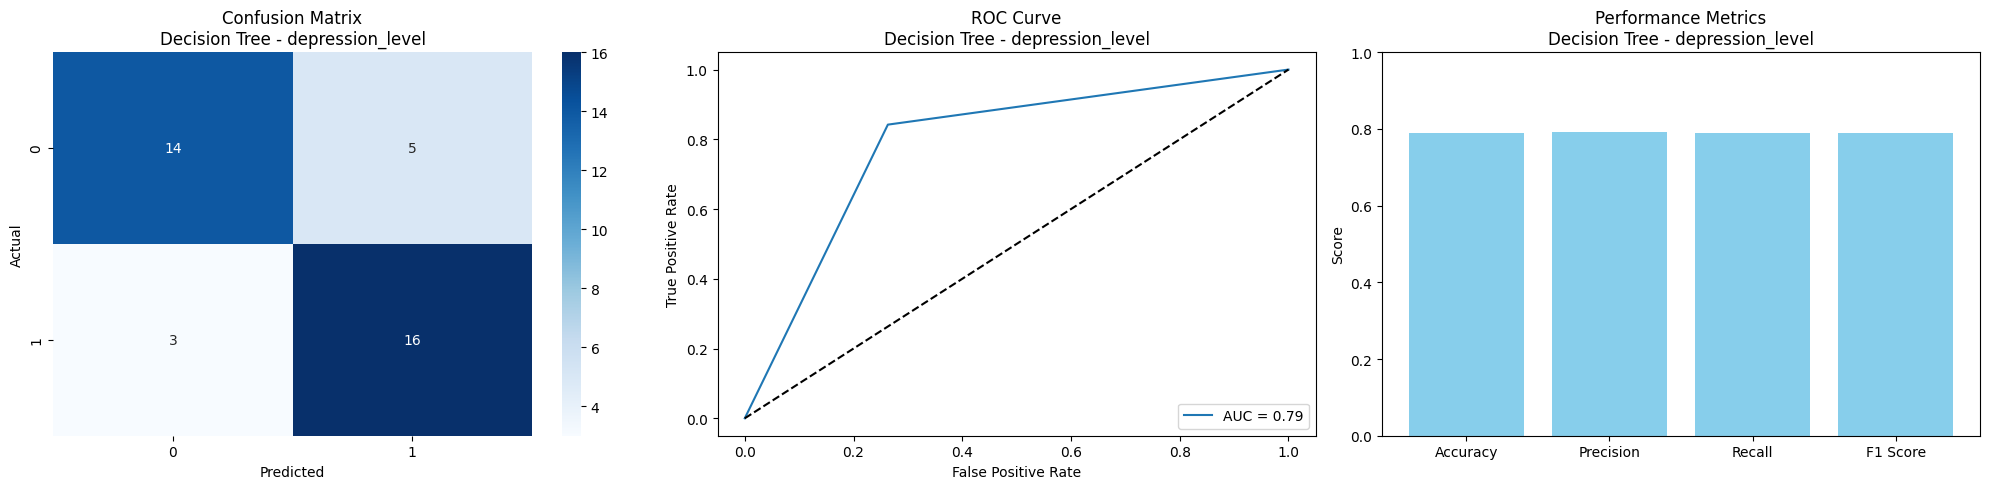

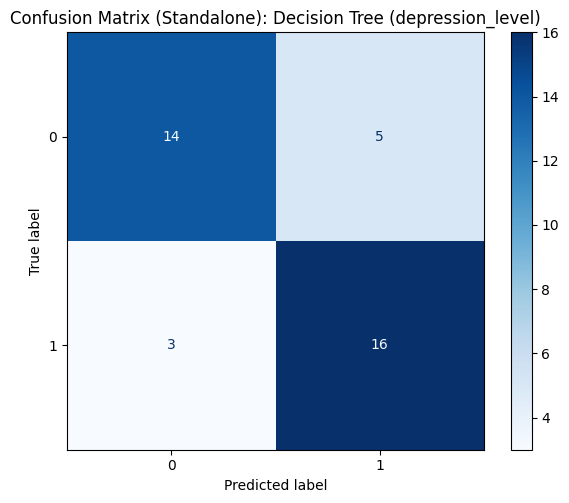


▶ Evaluating Model: SVM
  Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.86      0.95      0.90        19

    accuracy                           0.89        38
   macro avg       0.90      0.89      0.89        38
weighted avg       0.90      0.89      0.89        38



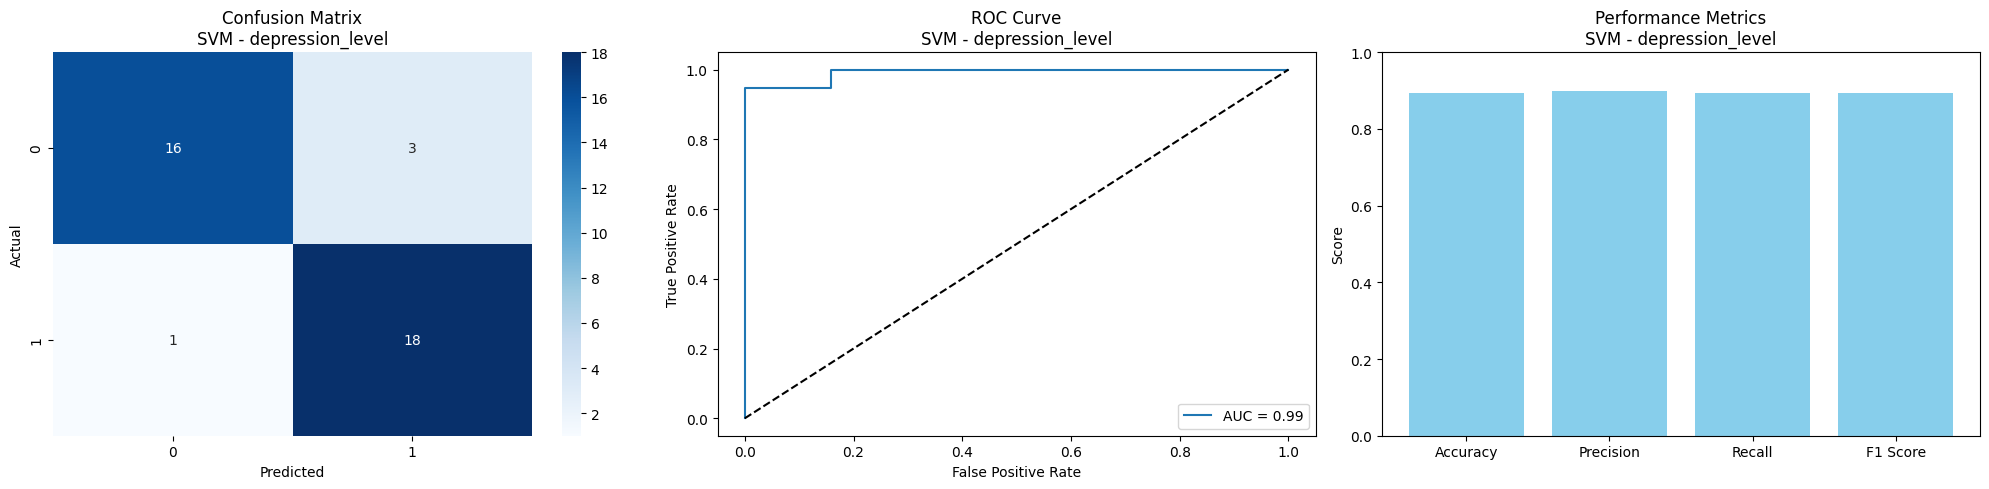

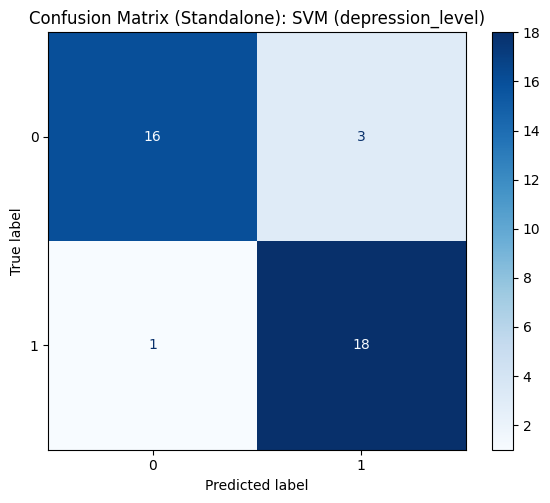


▶ Evaluating Model: Gaussian NB
  Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        19
           1       0.86      0.95      0.90        19

    accuracy                           0.89        38
   macro avg       0.90      0.89      0.89        38
weighted avg       0.90      0.89      0.89        38



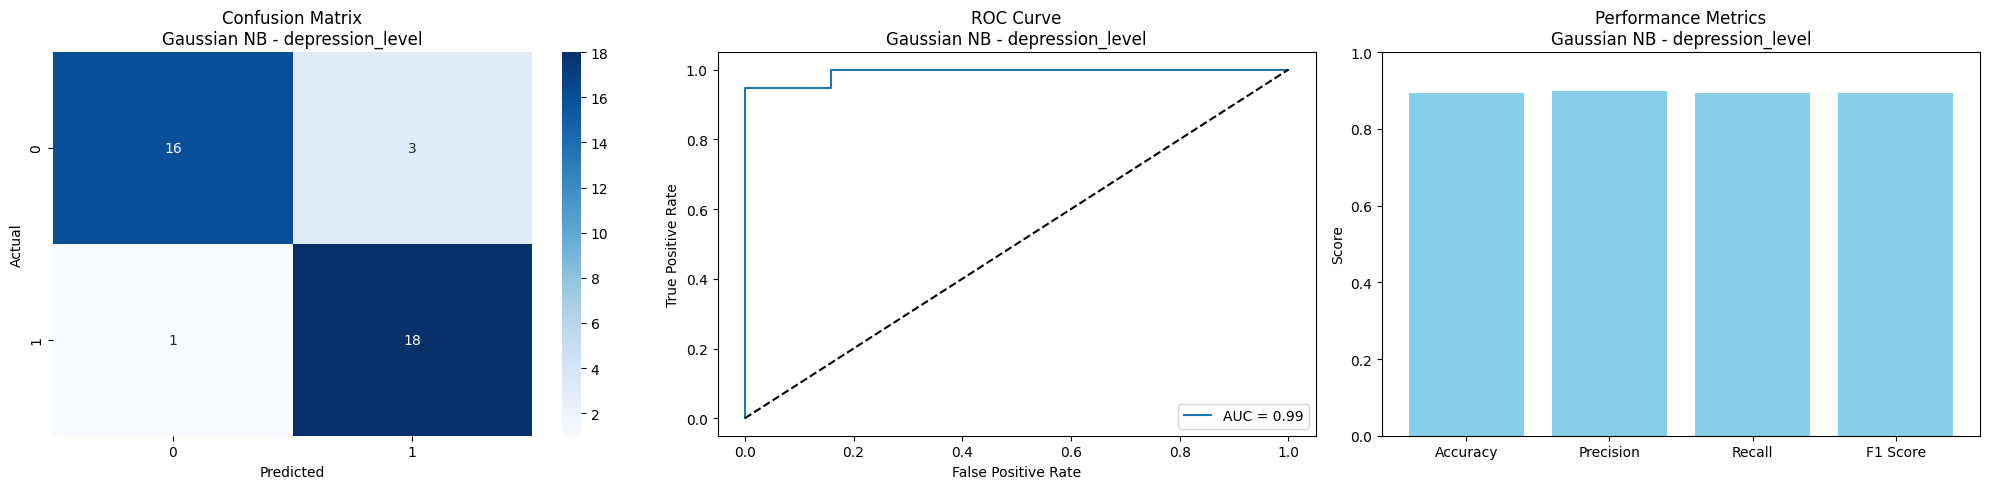

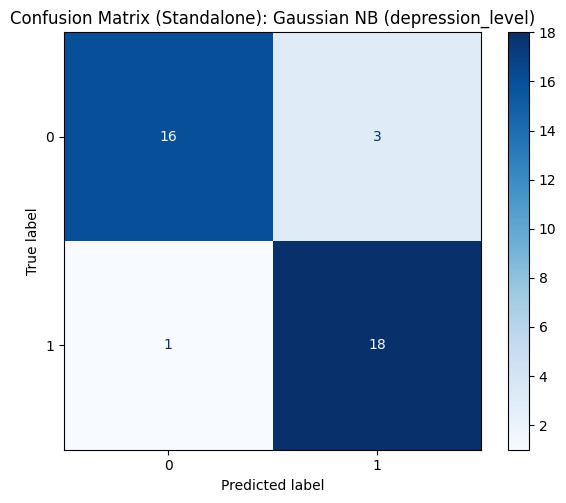


▶ Evaluating Model: Random Forest
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.86      1.00      0.93        19

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.93      0.92      0.92        38



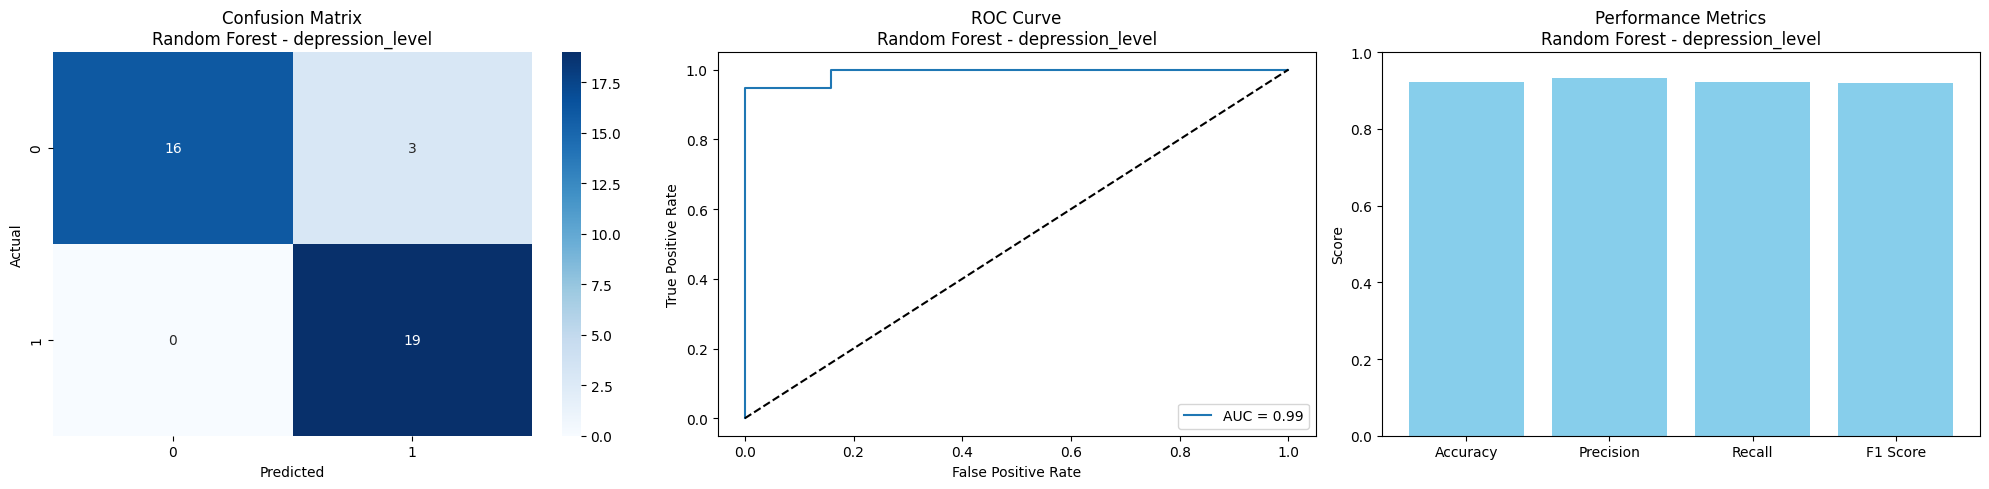

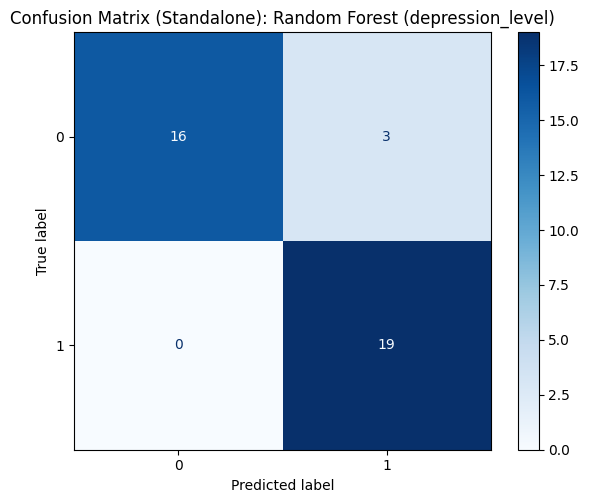


▶ Evaluating Model: Gradient Boosting
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.76      1.00      0.86        19

    accuracy                           0.84        38
   macro avg       0.88      0.84      0.84        38
weighted avg       0.88      0.84      0.84        38



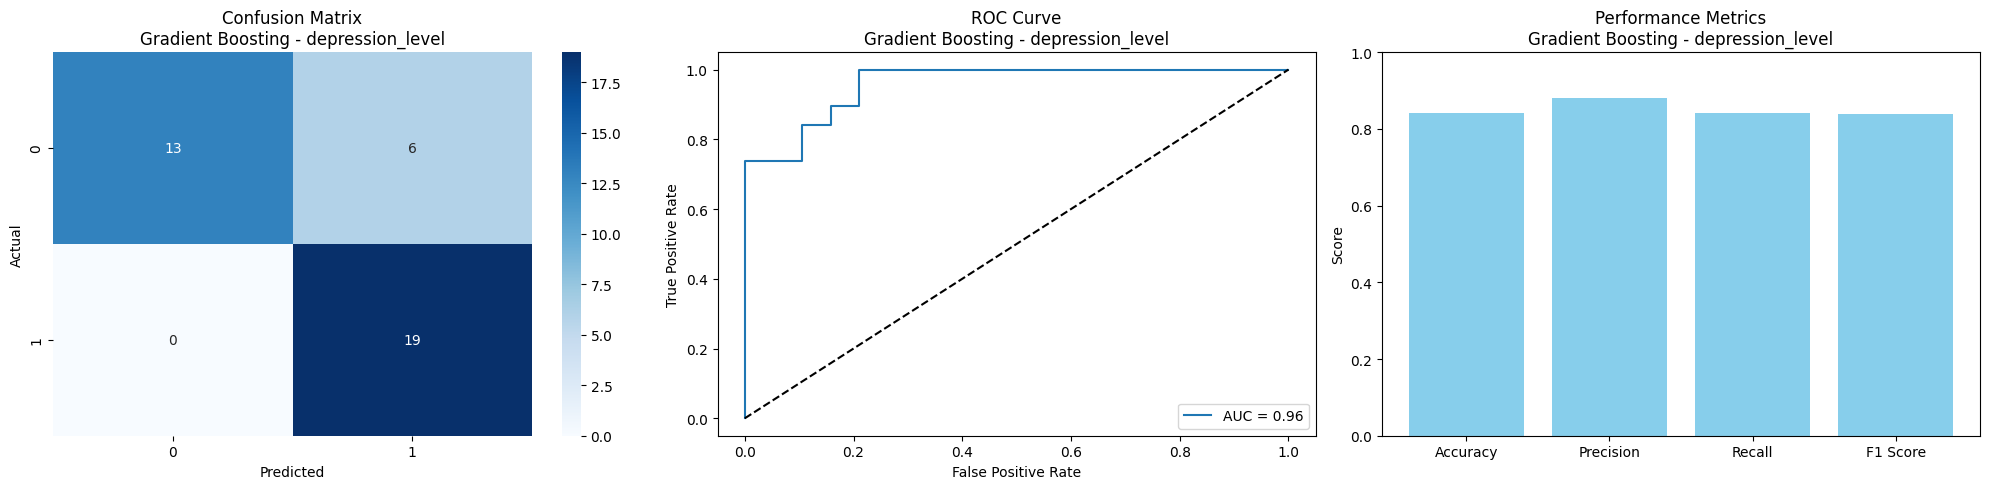

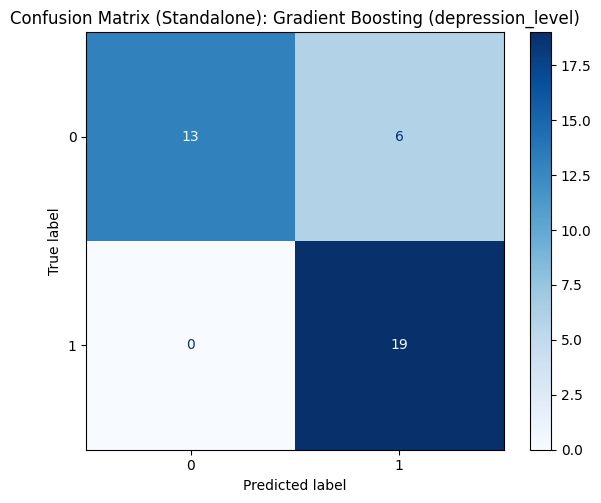


▶ Evaluating Model: XGBoost
  Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82        19
           1       0.78      0.95      0.86        19

    accuracy                           0.84        38
   macro avg       0.86      0.84      0.84        38
weighted avg       0.86      0.84      0.84        38



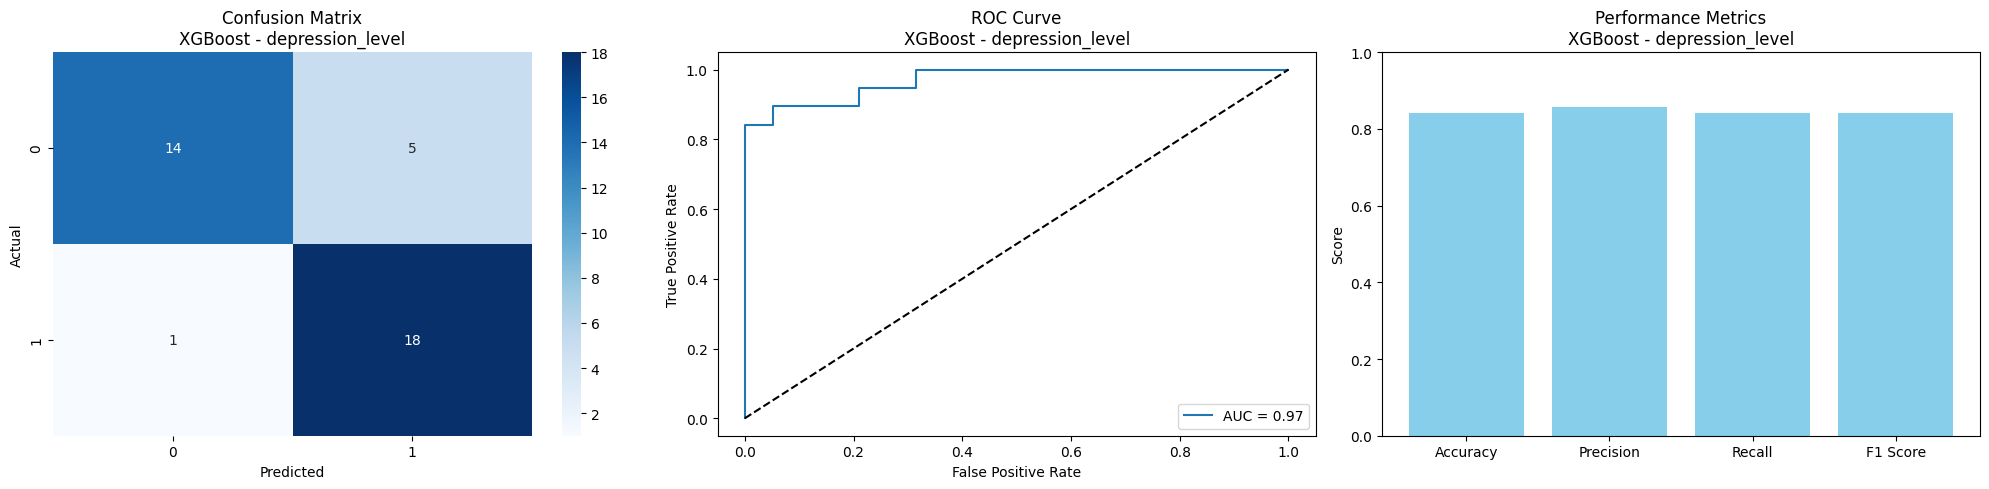

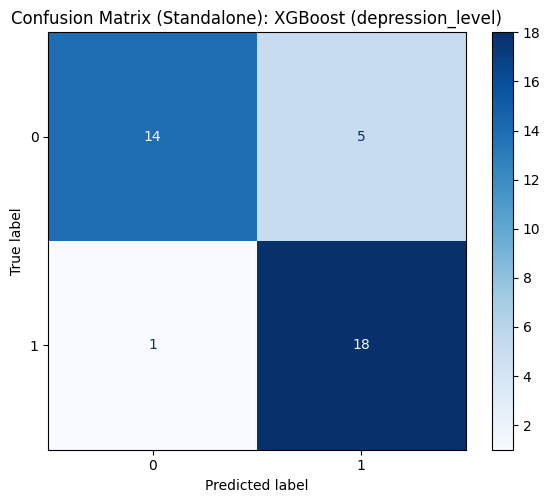


▶ Evaluating Model: Stack 1 (XGBoost + RF)
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       0.79      1.00      0.88        19

    accuracy                           0.87        38
   macro avg       0.90      0.87      0.87        38
weighted avg       0.90      0.87      0.87        38



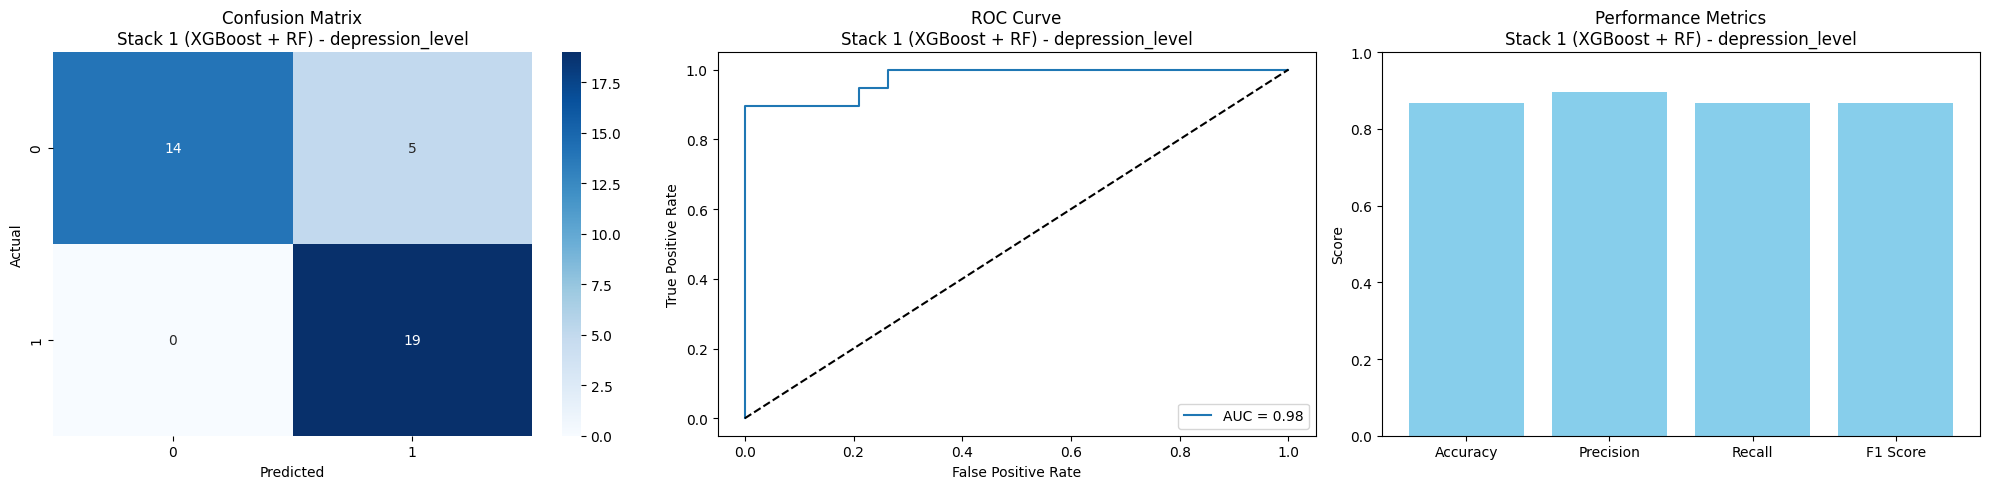

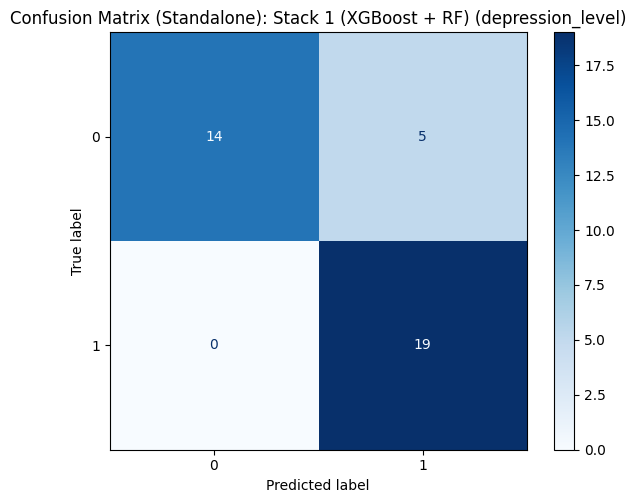


▶ Evaluating Model: Stack 2 (LogReg + GradBoost)
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        19
           1       0.76      1.00      0.86        19

    accuracy                           0.84        38
   macro avg       0.88      0.84      0.84        38
weighted avg       0.88      0.84      0.84        38



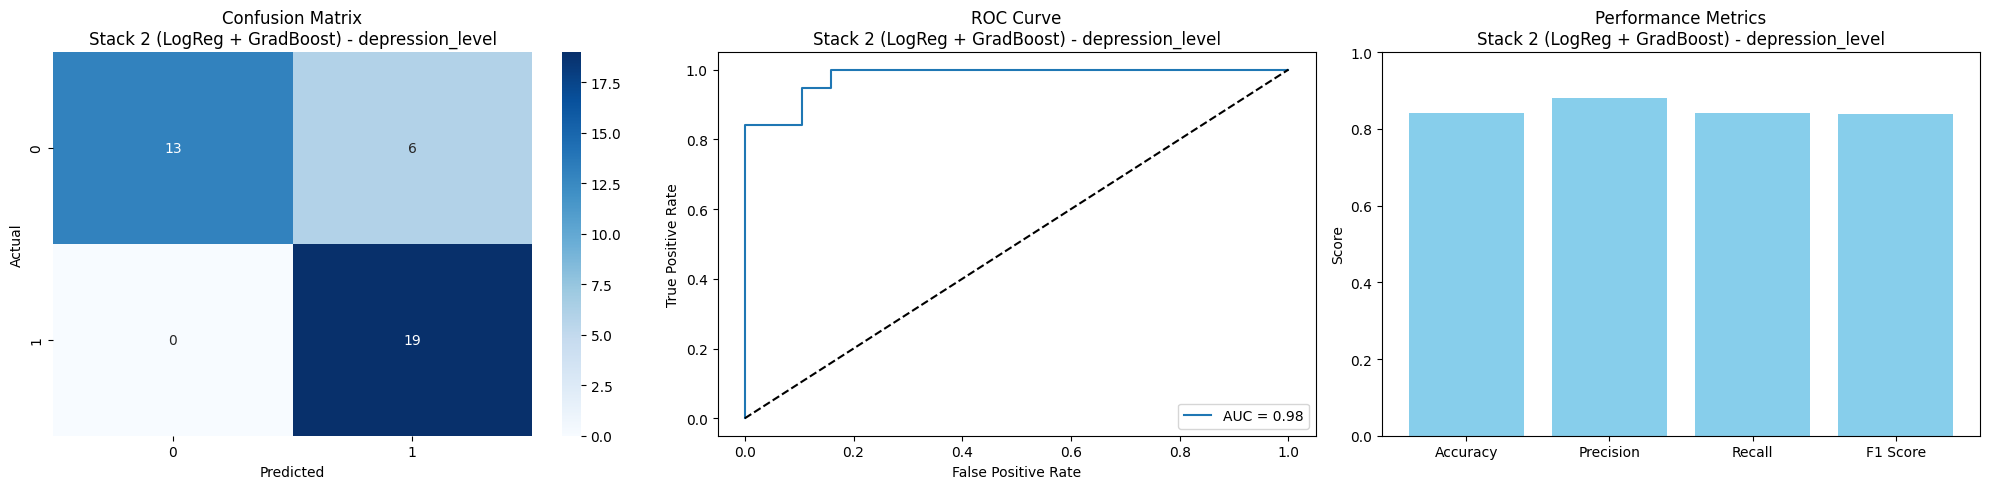

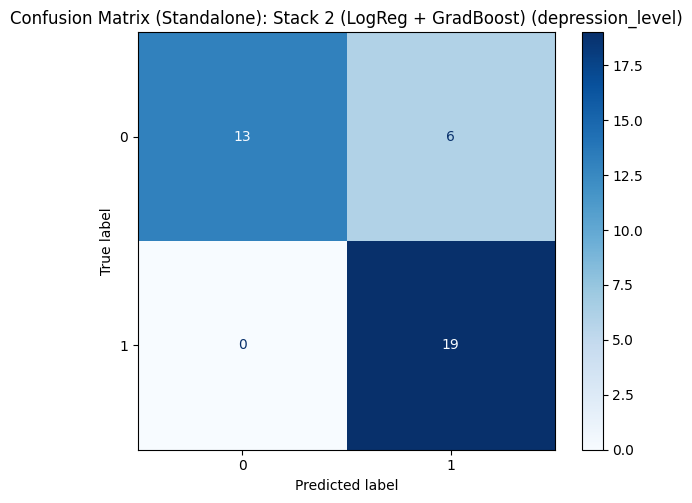


▶ Evaluating Model: Hybrid SVM+XGBoost
  Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        19
           1       0.89      0.89      0.89        19

    accuracy                           0.89        38
   macro avg       0.89      0.89      0.89        38
weighted avg       0.89      0.89      0.89        38



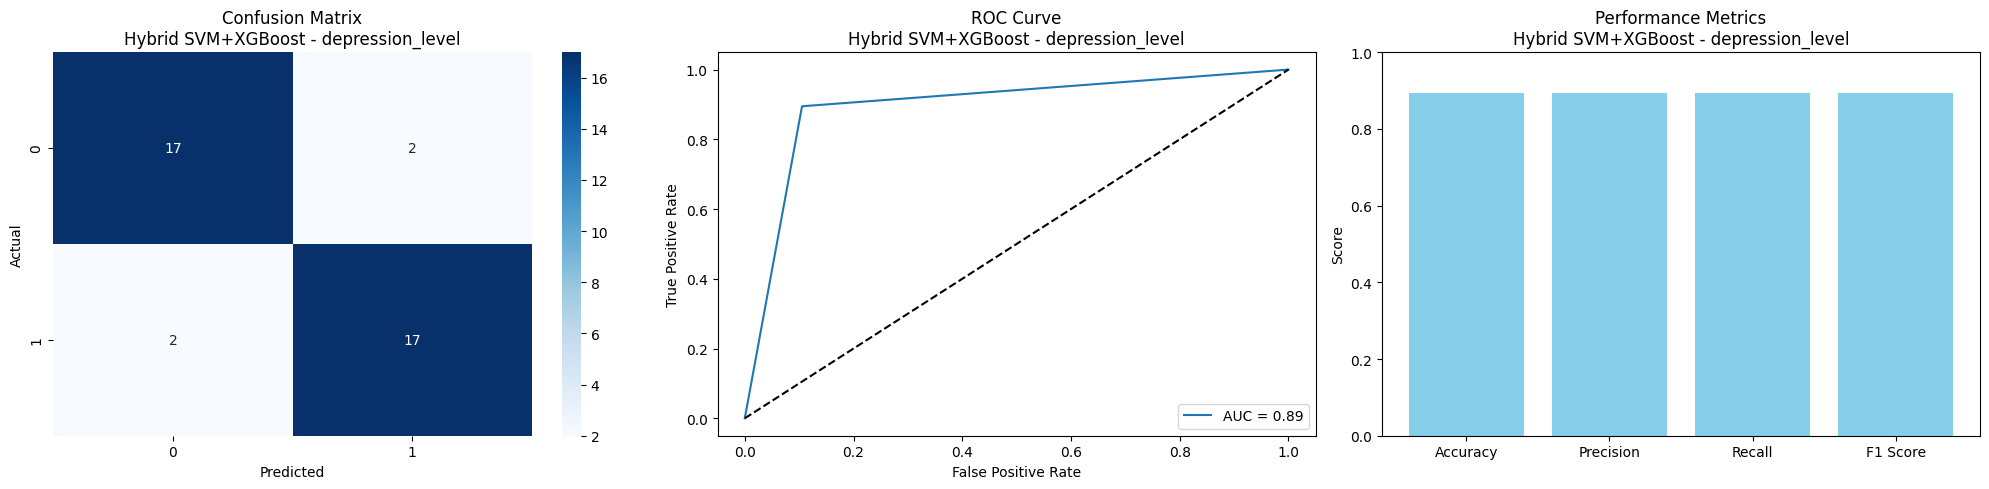

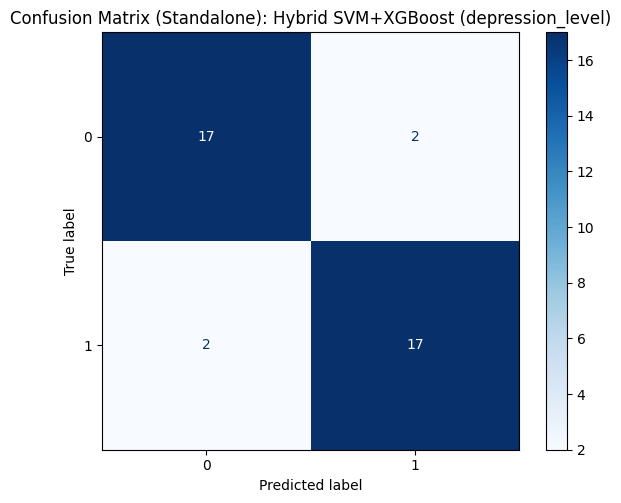


--- Metrics Summary for Target: depression_level ---
                          Model  Accuracy  Precision    Recall  F1 Score  \
0           Logistic Regression  0.842105   0.880000  0.842105  0.838068   
1                 Decision Tree  0.789474   0.792717  0.789474  0.788889   
2                           SVM  0.894737   0.899160  0.894737  0.894444   
3                   Gaussian NB  0.894737   0.899160  0.894737  0.894444   
4                 Random Forest  0.921053   0.931818  0.921053  0.920557   
5             Gradient Boosting  0.842105   0.880000  0.842105  0.838068   
6                       XGBoost  0.842105   0.857971  0.842105  0.840336   
7        Stack 1 (XGBoost + RF)  0.868421   0.895833  0.868421  0.866103   
8  Stack 2 (LogReg + GradBoost)  0.842105   0.880000  0.842105  0.838068   
9            Hybrid SVM+XGBoost  0.894737   0.894737  0.894737  0.894737   

    ROC-AUC  
0  0.983380  
1  0.789474  
2  0.991690  
3  0.991690  
4  0.991690  
5  0.958449  
6  0.969529

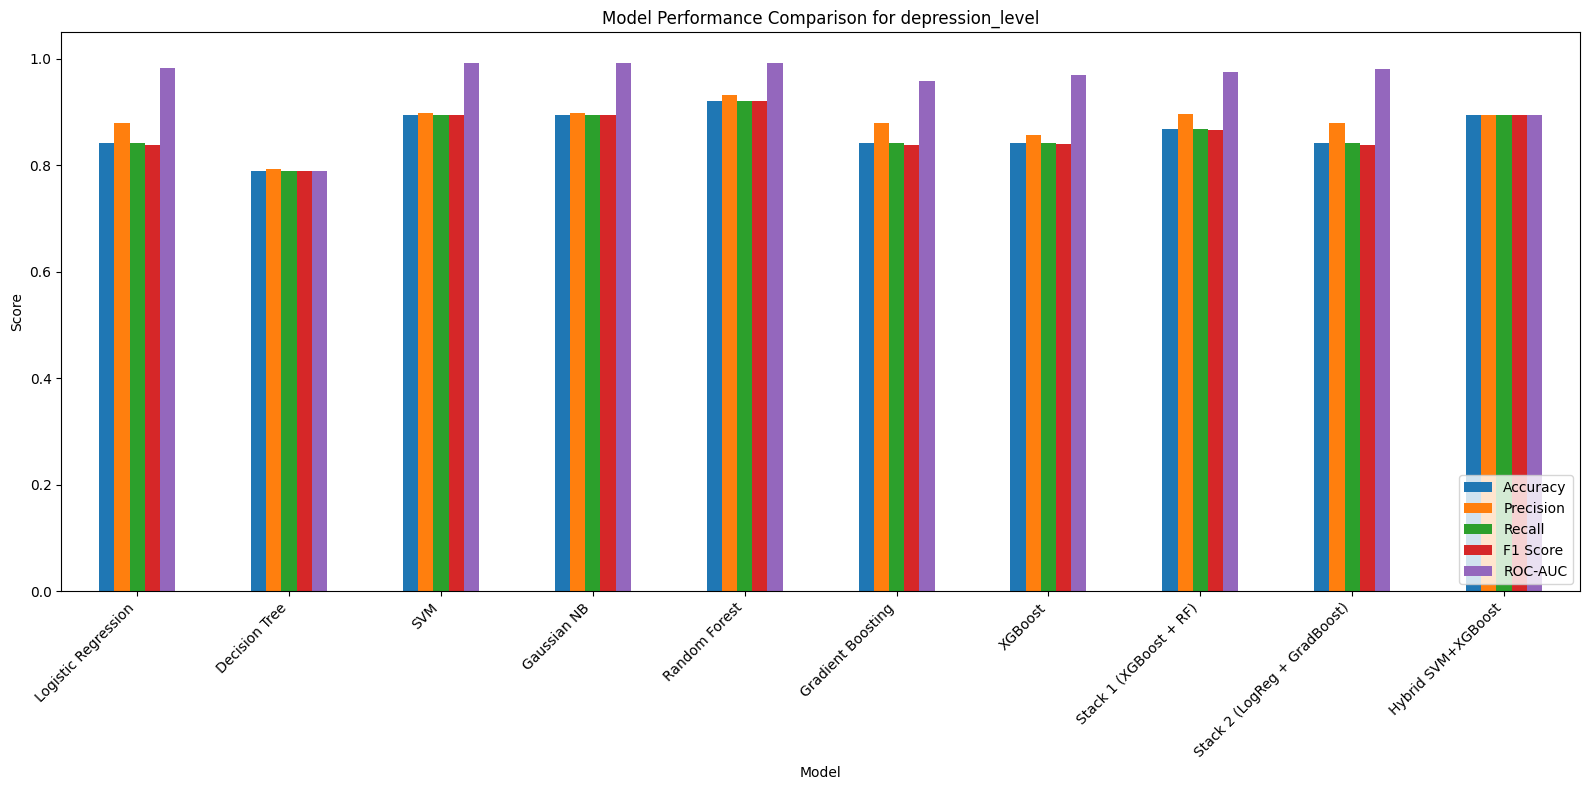



==================== Target Variable: life_satisfication_level ====================

--- Training All Models ---
  Training Individual Models...
    Successfully trained Logistic Regression.
    Successfully trained Decision Tree.
    Successfully trained SVM.
    Successfully trained Gaussian NB.
    Successfully trained Random Forest.
    Successfully trained Gradient Boosting.
    Successfully trained XGBoost.
  Training Stacking Models...
    Successfully trained Stack 1.
    Successfully trained Stack 2.
  Training Hybrid SVM + XGBoost Model...
    Successfully trained Hybrid SVM+XGBoost.


--- Comprehensive Evaluation & Plotting for Target: life_satisfication_level ---

▶ Evaluating Model: Logistic Regression
  Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        21
           1       0.90      0.90      0.90        20

    accuracy                           0.90        41
   macro avg       0.90      0

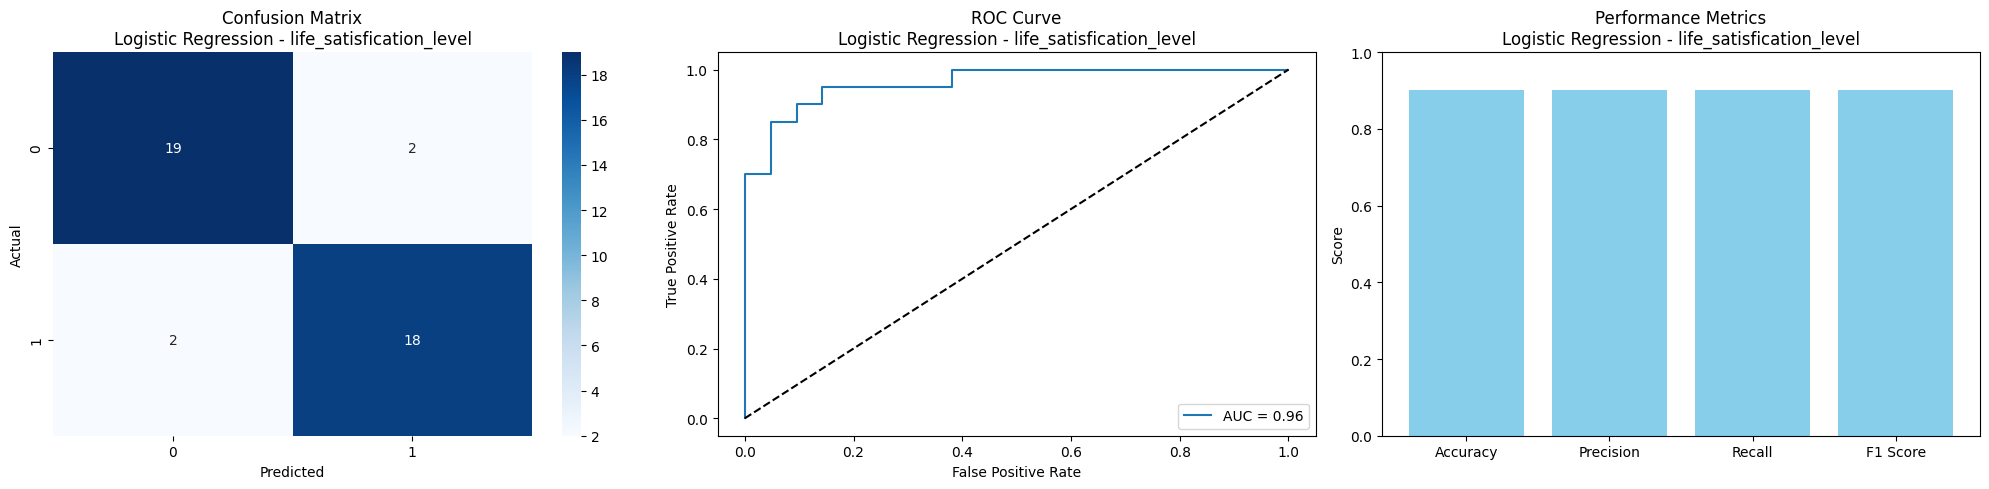

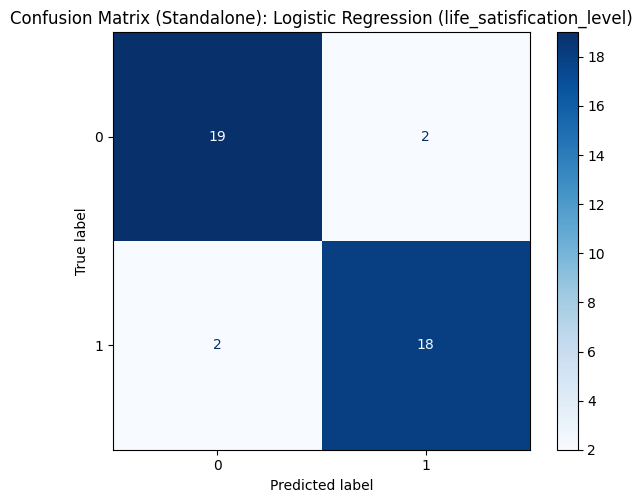


▶ Evaluating Model: Decision Tree
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.91      1.00      0.95        20

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.96      0.95      0.95        41



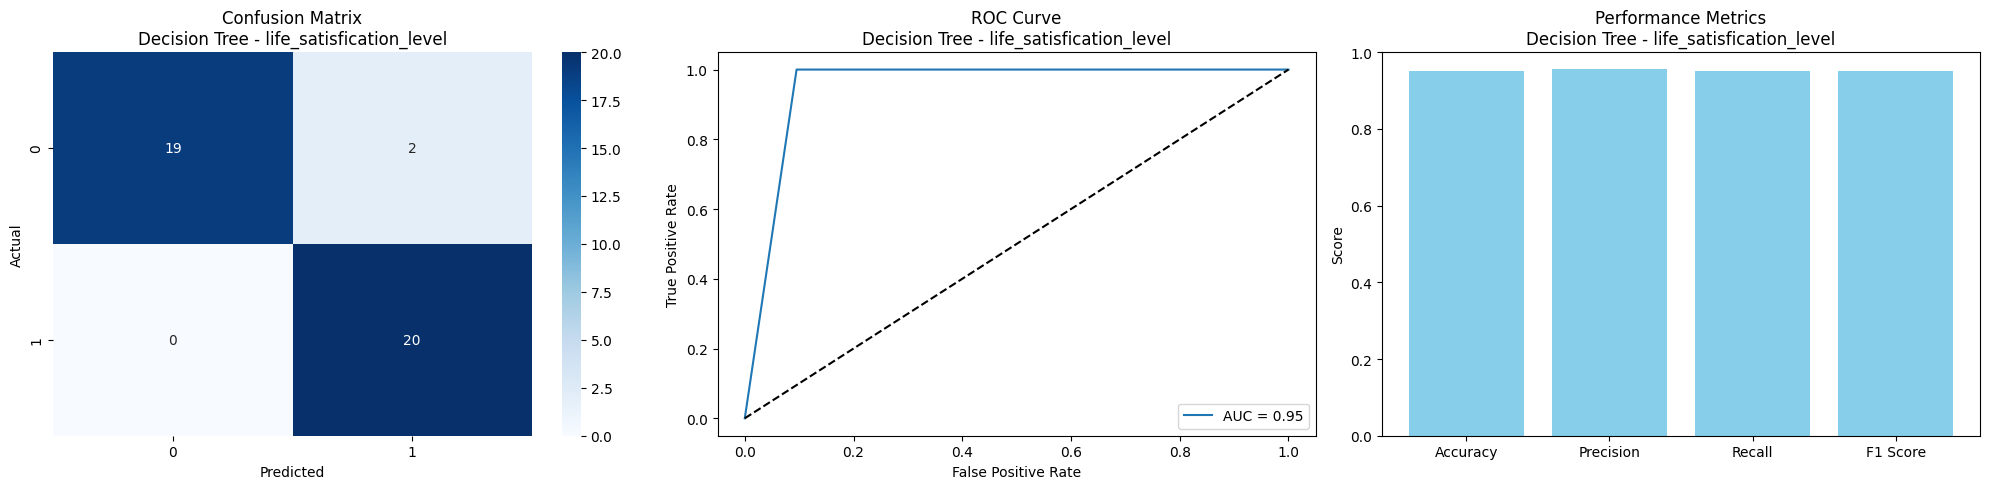

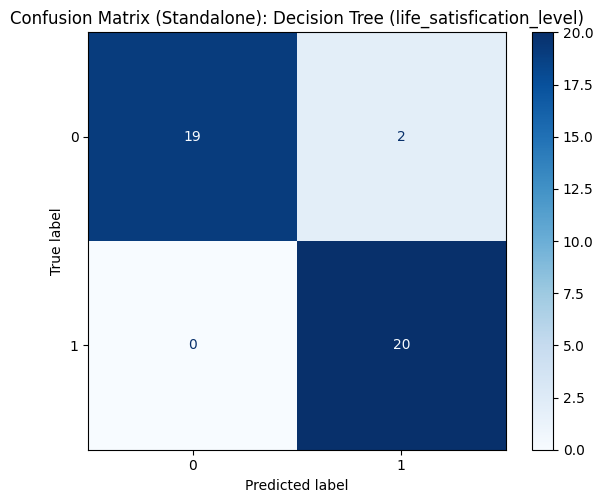


▶ Evaluating Model: SVM
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.91      1.00      0.95        20

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.96      0.95      0.95        41



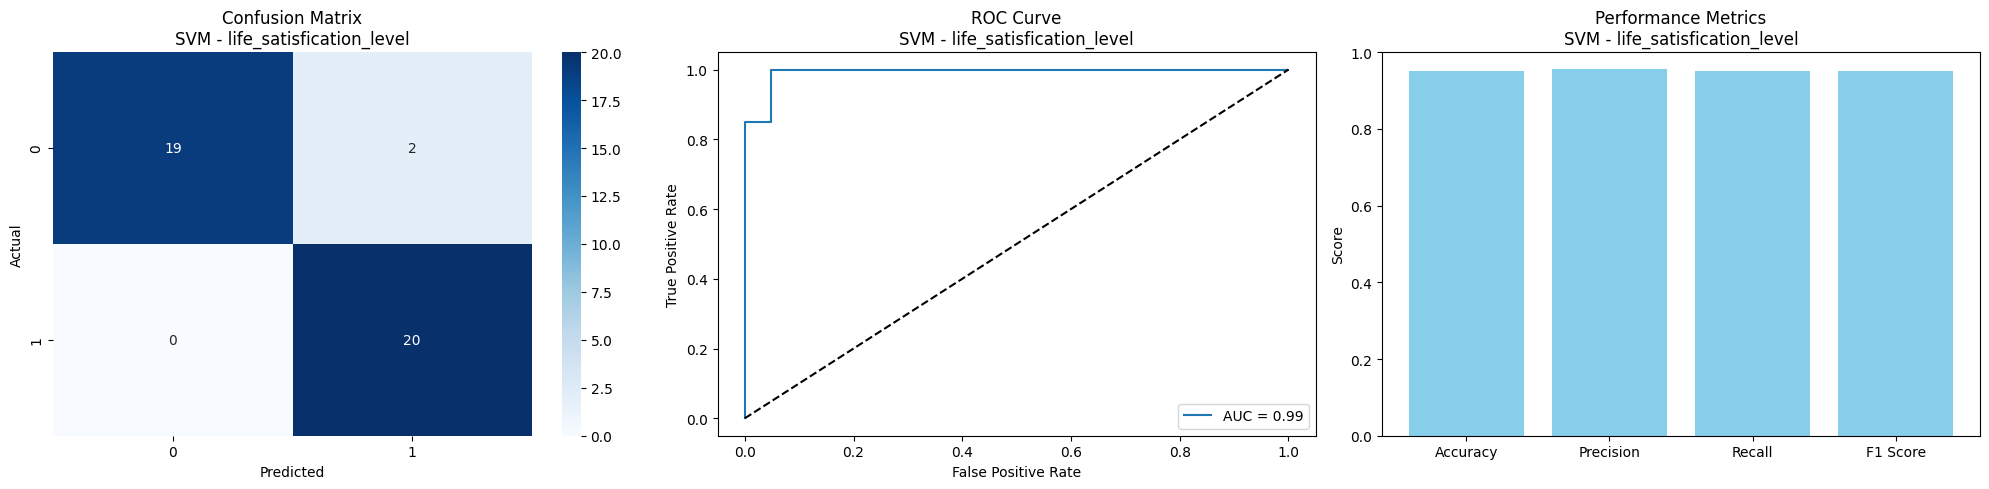

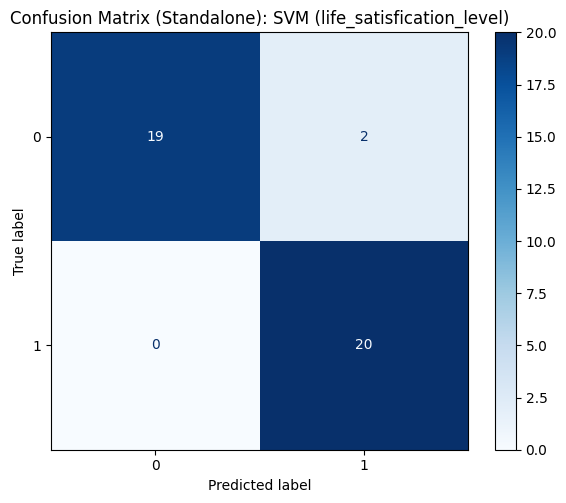


▶ Evaluating Model: Gaussian NB
  Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.88      0.75      0.81        20

    accuracy                           0.83        41
   macro avg       0.84      0.83      0.83        41
weighted avg       0.84      0.83      0.83        41



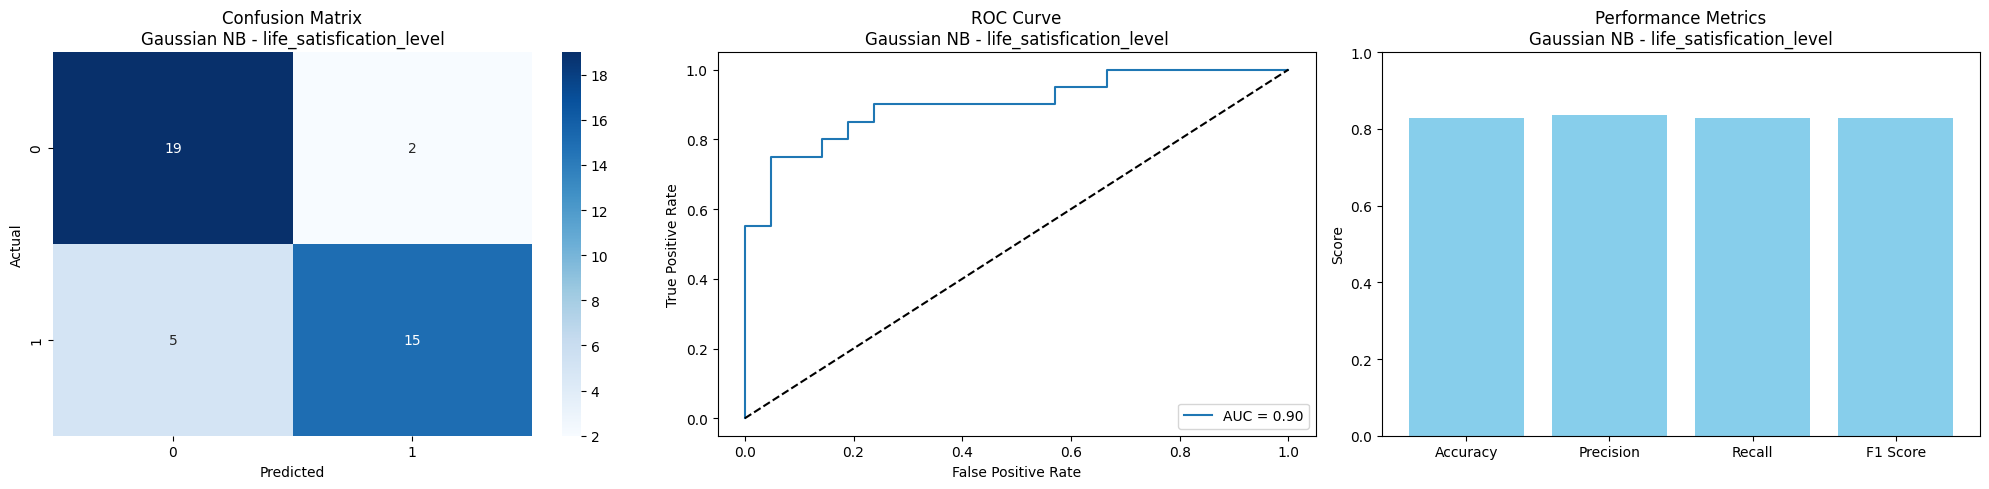

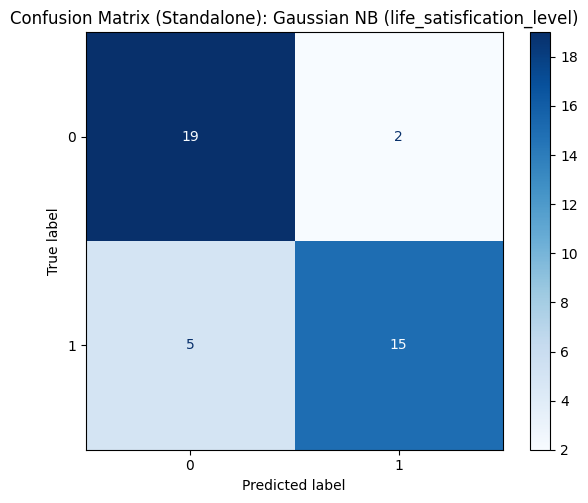


▶ Evaluating Model: Random Forest
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.95      0.95      0.95        20

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.95      0.95      0.95        41



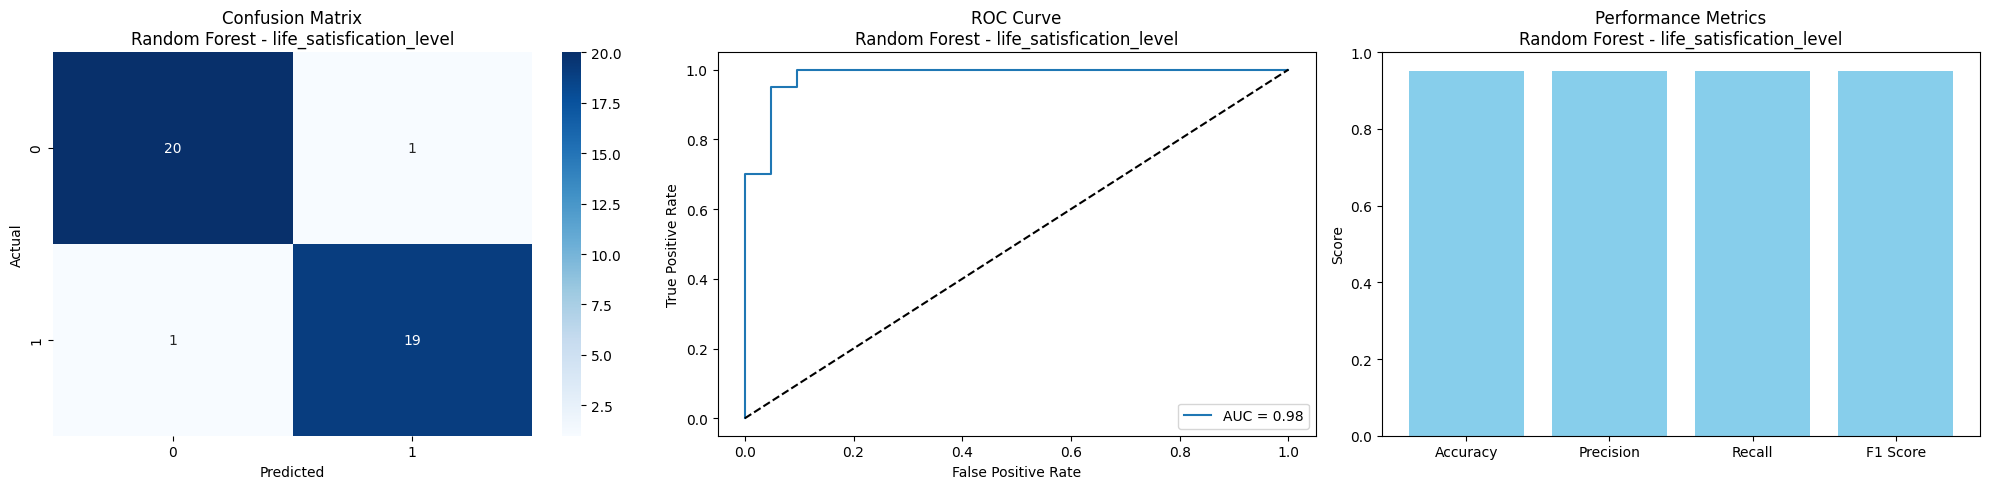

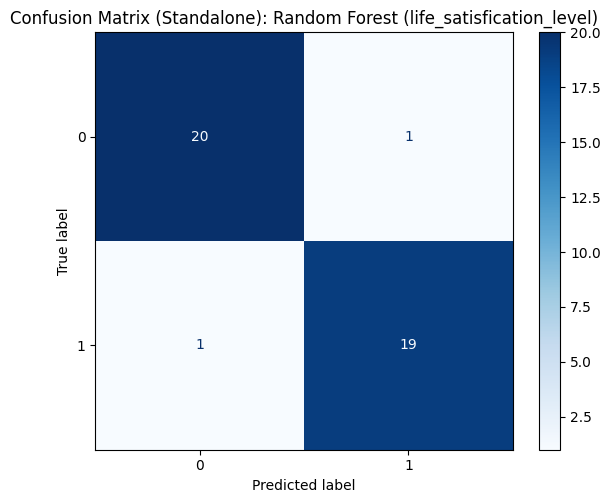


▶ Evaluating Model: Gradient Boosting
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.95      0.95      0.95        20

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.95      0.95      0.95        41



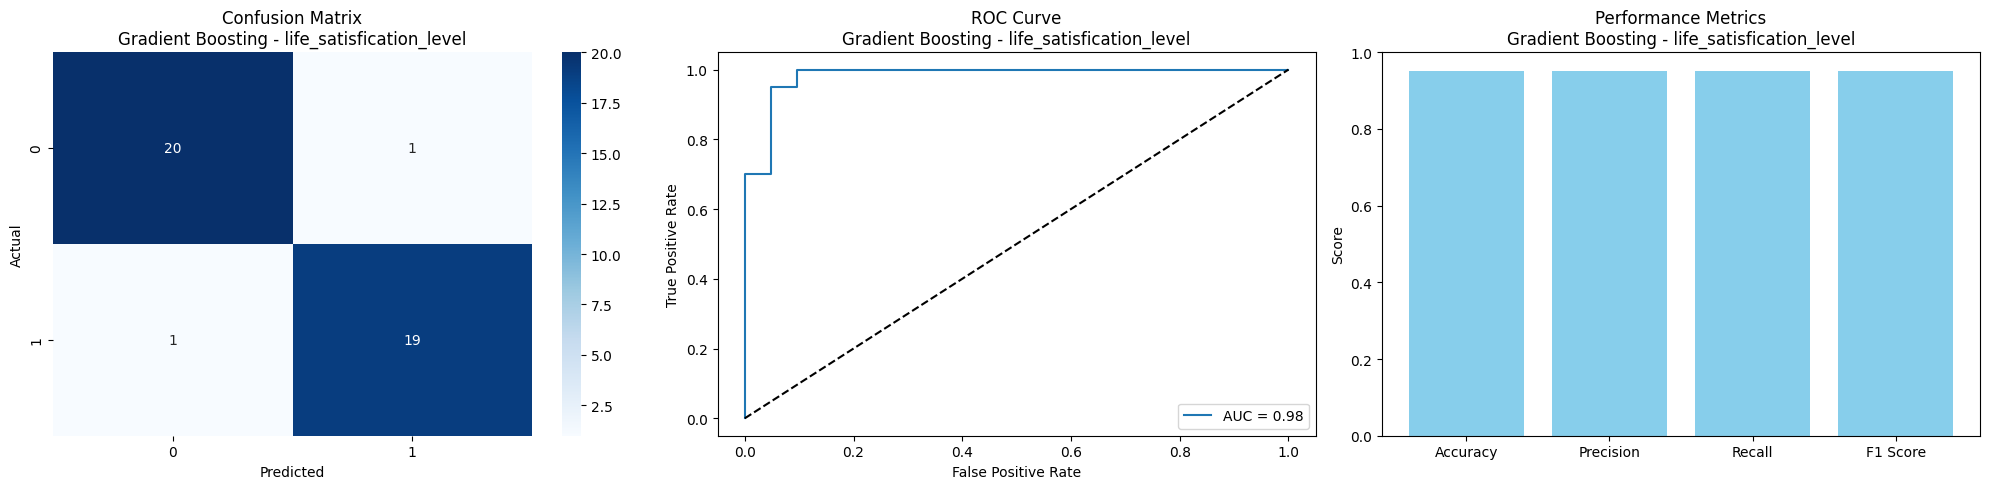

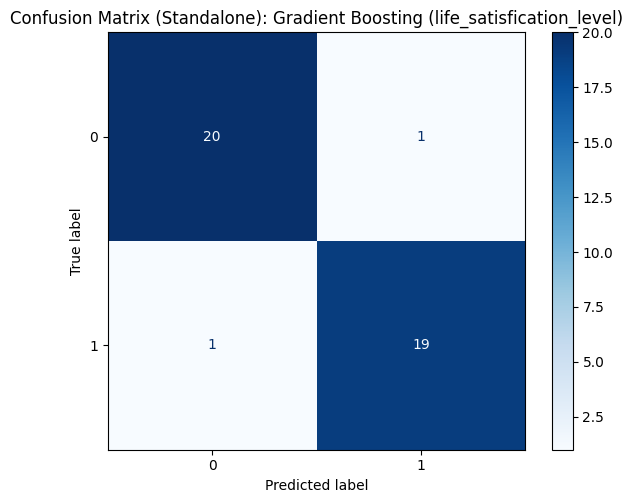


▶ Evaluating Model: XGBoost
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.98        20

    accuracy                           0.98        41
   macro avg       0.98      0.98      0.98        41
weighted avg       0.98      0.98      0.98        41



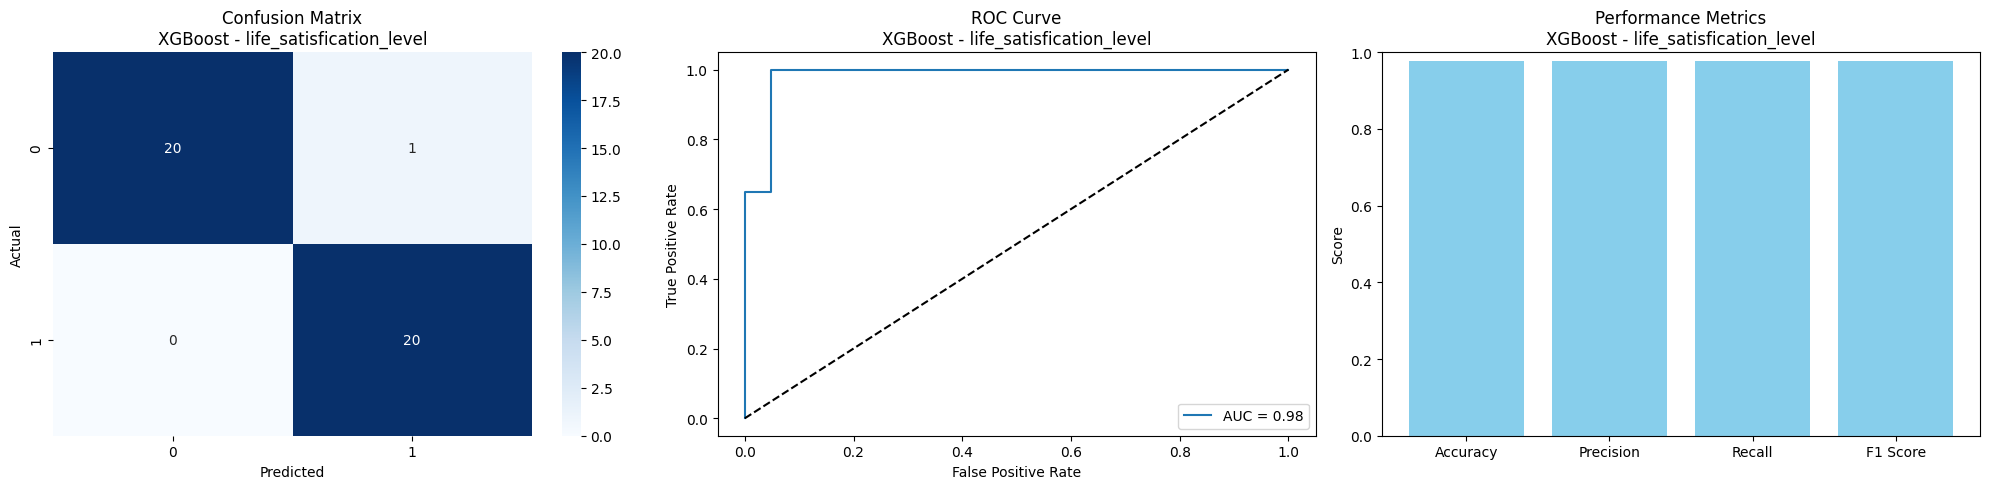

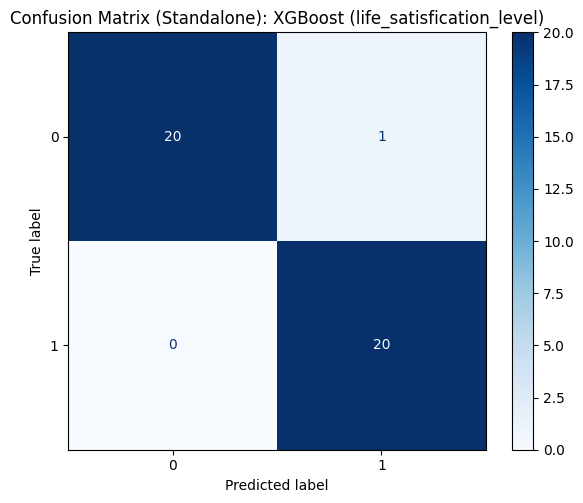


▶ Evaluating Model: Stack 1 (XGBoost + RF)
  Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.98        20

    accuracy                           0.98        41
   macro avg       0.98      0.98      0.98        41
weighted avg       0.98      0.98      0.98        41



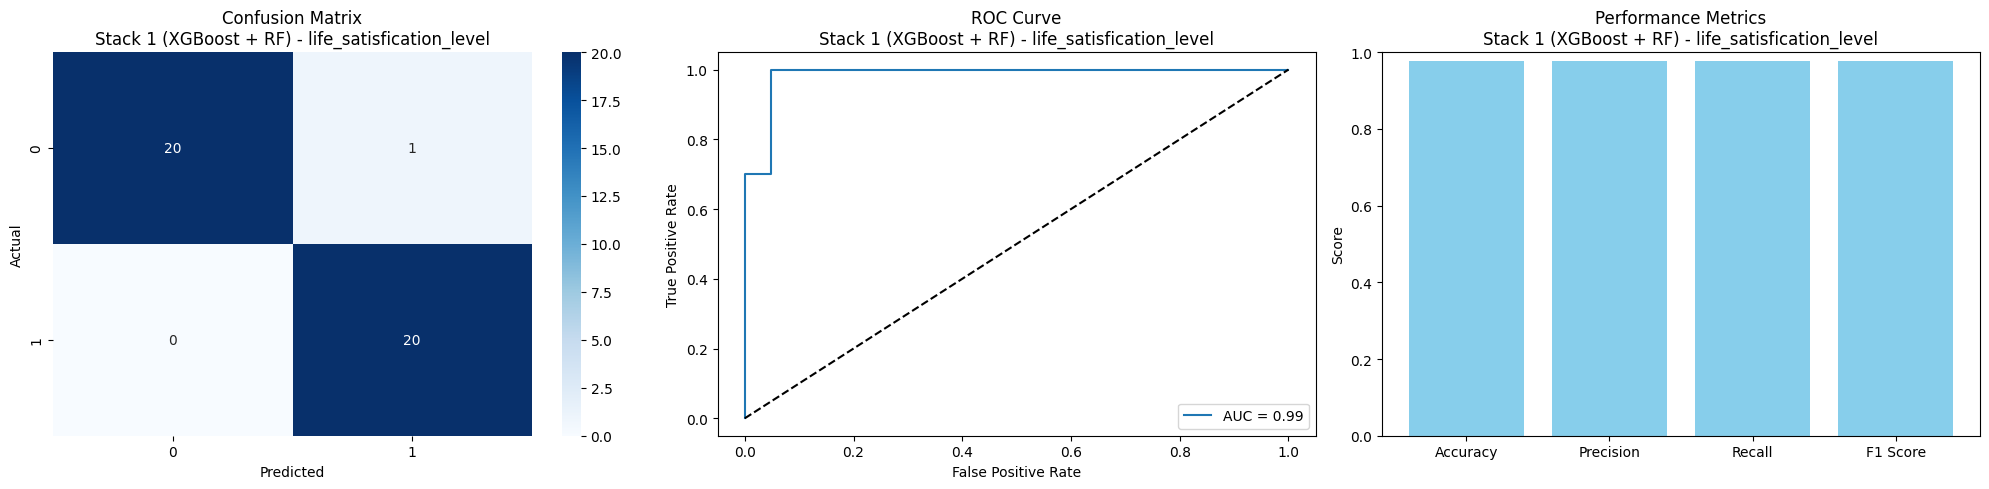

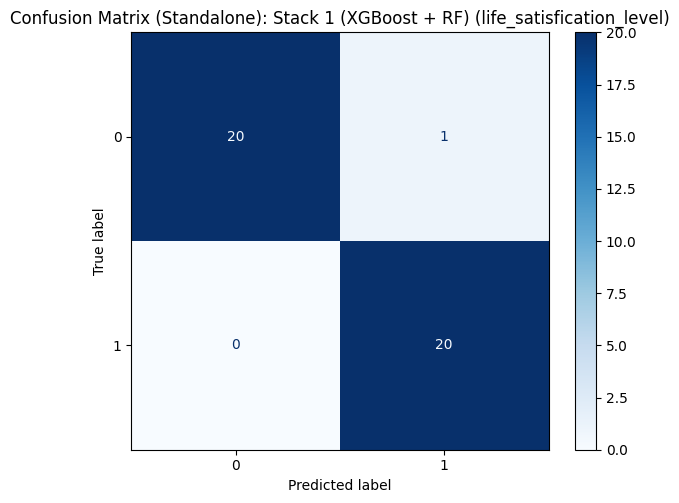


▶ Evaluating Model: Stack 2 (LogReg + GradBoost)
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        21
           1       0.95      0.95      0.95        20

    accuracy                           0.95        41
   macro avg       0.95      0.95      0.95        41
weighted avg       0.95      0.95      0.95        41



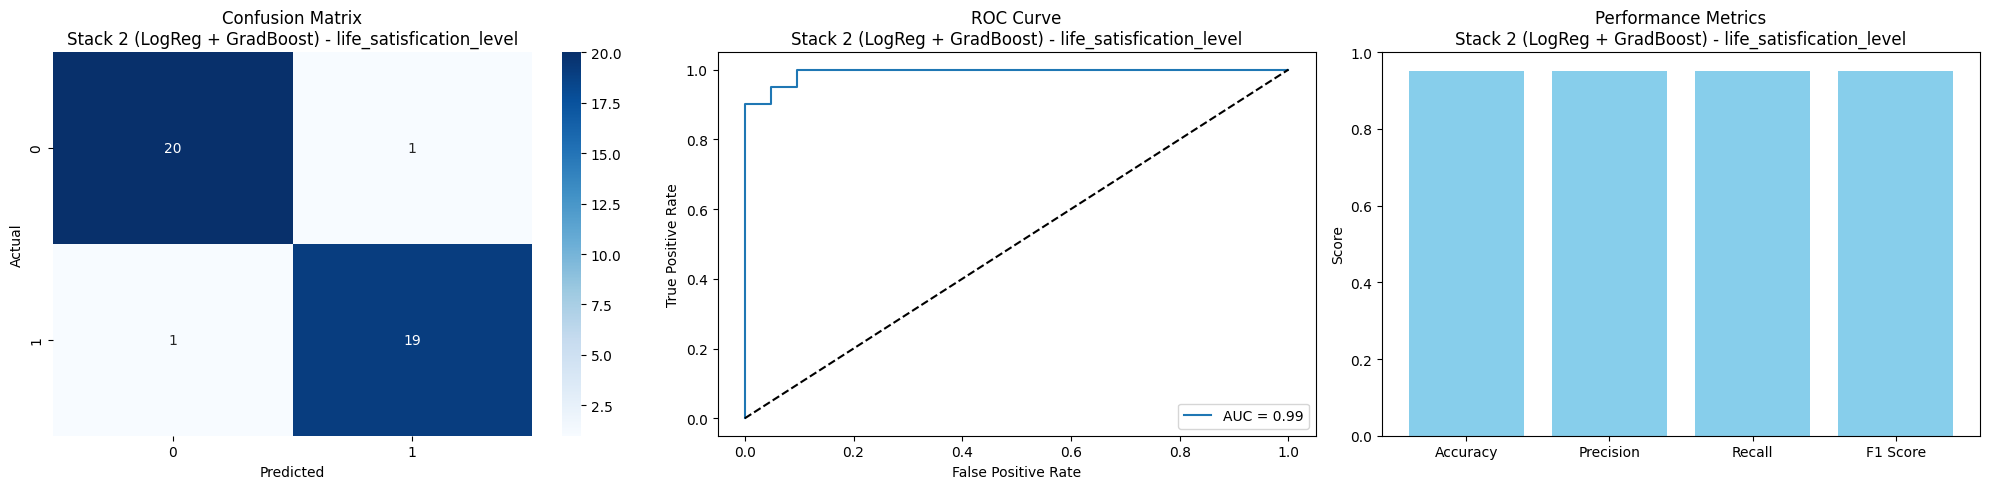

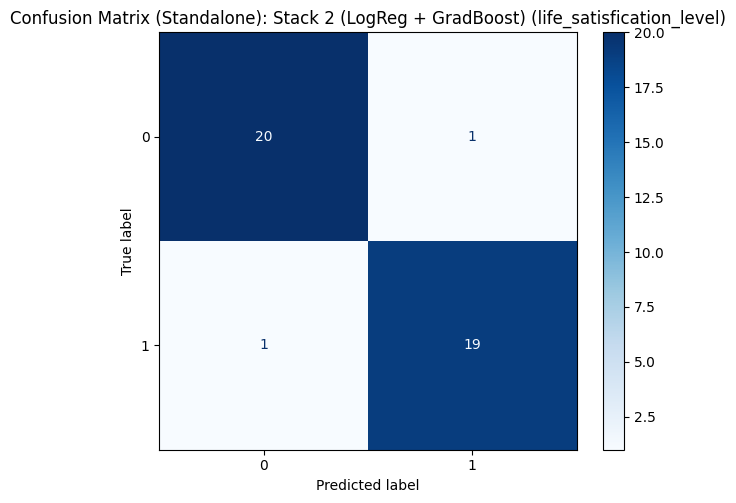


▶ Evaluating Model: Hybrid SVM+XGBoost
  Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        21
           1       1.00      0.95      0.97        20

    accuracy                           0.98        41
   macro avg       0.98      0.97      0.98        41
weighted avg       0.98      0.98      0.98        41



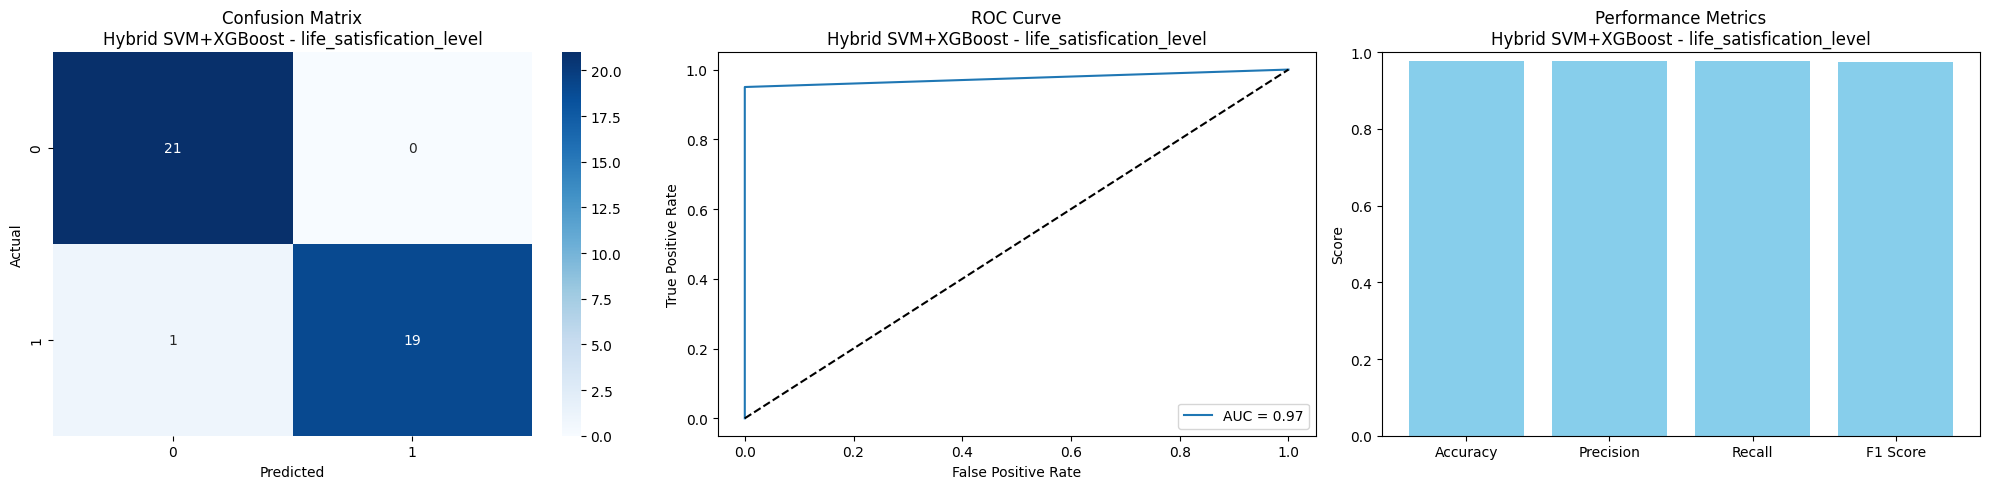

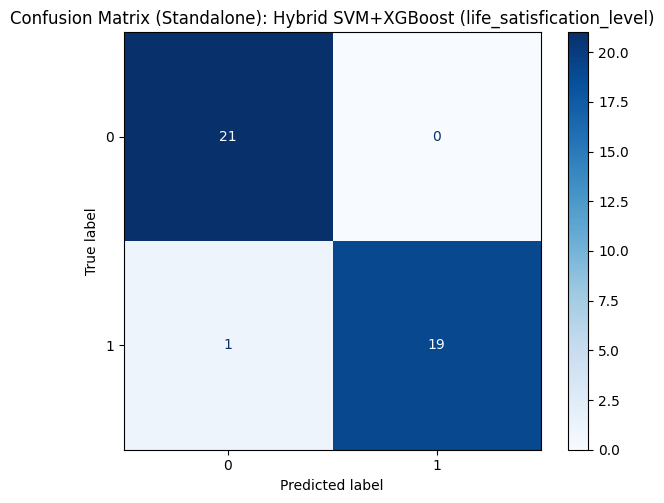


--- Metrics Summary for Target: life_satisfication_level ---
                          Model  Accuracy  Precision    Recall  F1 Score  \
0           Logistic Regression  0.902439   0.902439  0.902439  0.902439   
1                 Decision Tree  0.951220   0.955654  0.951220  0.951161   
2                           SVM  0.951220   0.955654  0.951220  0.951161   
3                   Gaussian NB  0.829268   0.835904  0.829268  0.828038   
4                 Random Forest  0.951220   0.951220  0.951220  0.951220   
5             Gradient Boosting  0.951220   0.951220  0.951220  0.951220   
6                       XGBoost  0.975610   0.976771  0.975610  0.975610   
7        Stack 1 (XGBoost + RF)  0.975610   0.976771  0.975610  0.975610   
8  Stack 2 (LogReg + GradBoost)  0.951220   0.951220  0.951220  0.951220   
9            Hybrid SVM+XGBoost  0.975610   0.976718  0.975610  0.975581   

    ROC-AUC  
0  0.961905  
1  0.952381  
2  0.992857  
3  0.900000  
4  0.983333  
5  0.983333  
6  

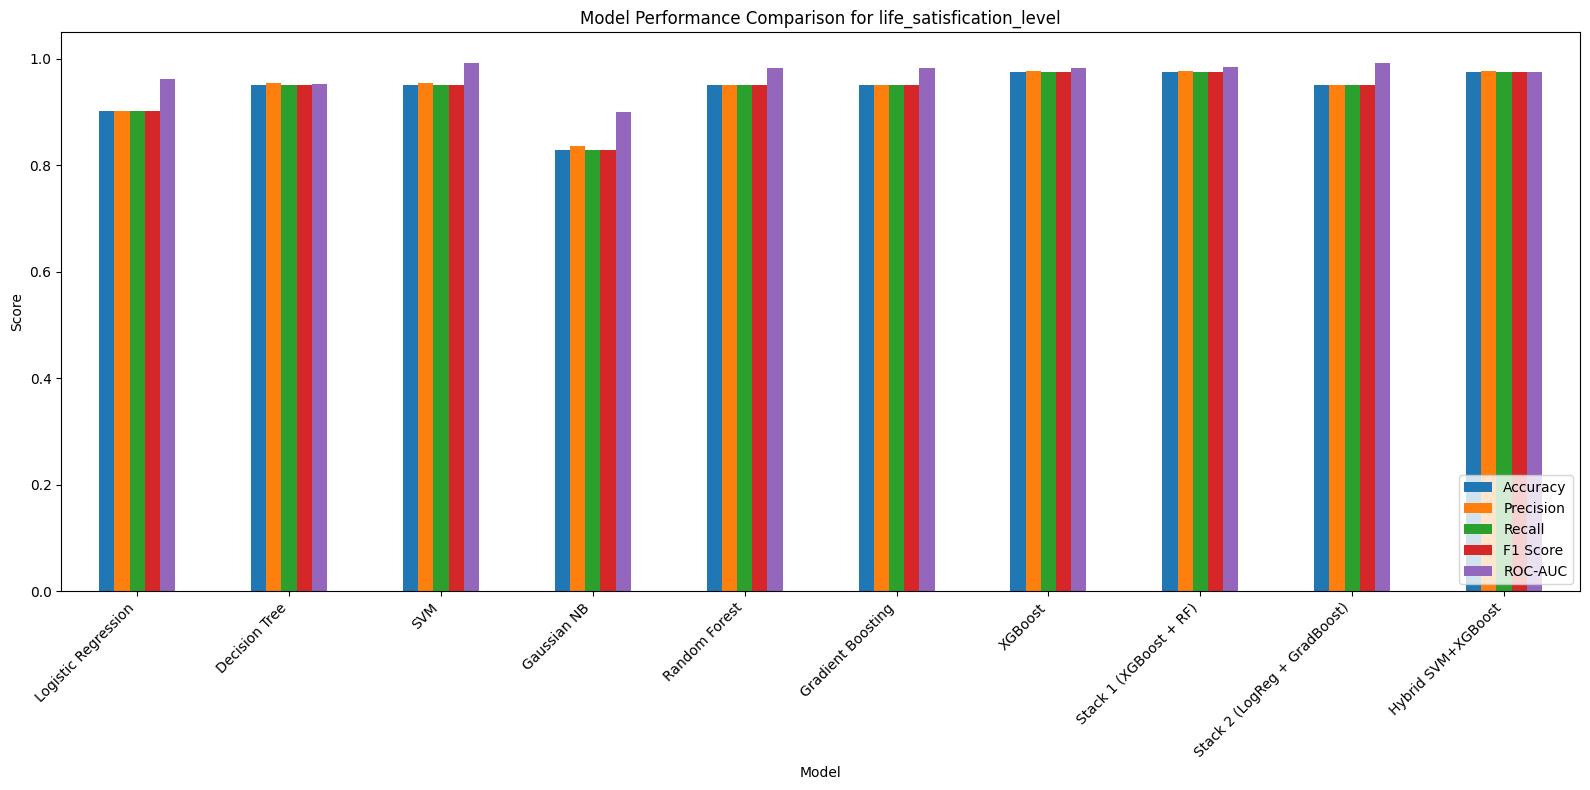



==================== Target Variable: Big_five_personality_level ====================

--- Training All Models ---
  Training Individual Models...
    Successfully trained Logistic Regression.
    Successfully trained Decision Tree.
    Successfully trained SVM.
    Successfully trained Gaussian NB.
    Successfully trained Random Forest.
    Successfully trained Gradient Boosting.
    Successfully trained XGBoost.
  Training Stacking Models...
    Successfully trained Stack 1.
    Successfully trained Stack 2.
  Training Hybrid SVM + XGBoost Model...
    Successfully trained Hybrid SVM+XGBoost.


--- Comprehensive Evaluation & Plotting for Target: Big_five_personality_level ---

▶ Evaluating Model: Logistic Regression
  Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.77        21
           1       0.78      0.70      0.74        20

    accuracy                           0.76        41
   macro avg       0.76   

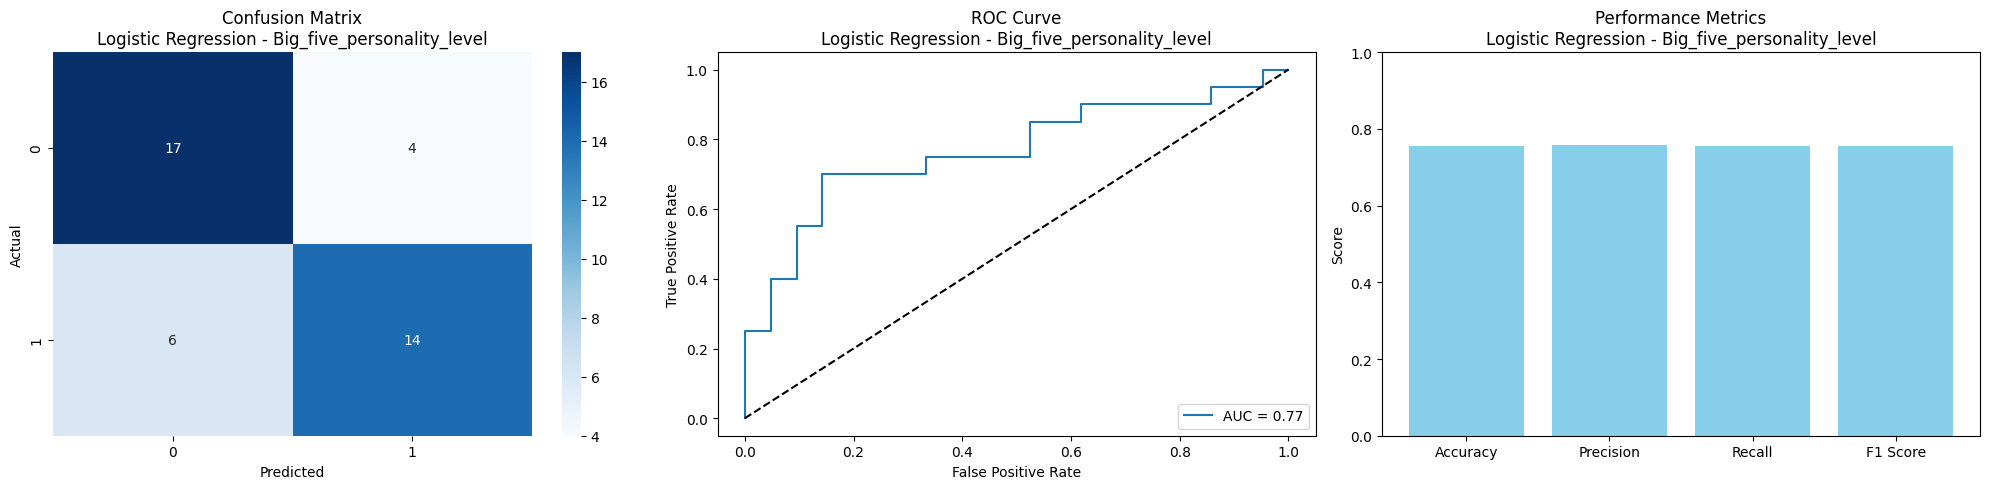

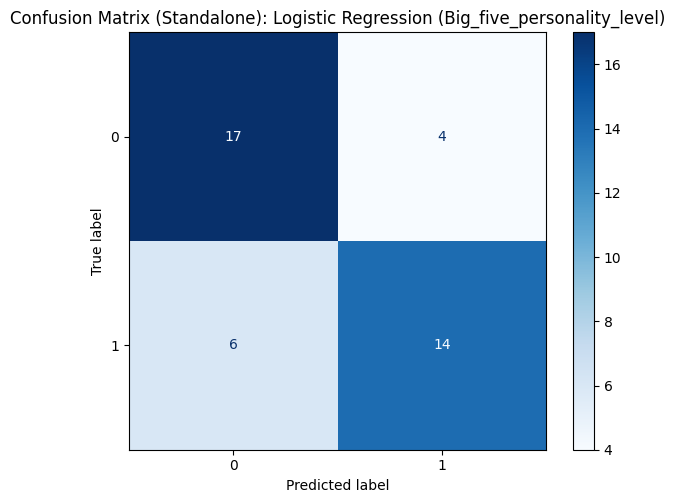


▶ Evaluating Model: Decision Tree
  Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.74      0.70      0.72        20

    accuracy                           0.73        41
   macro avg       0.73      0.73      0.73        41
weighted avg       0.73      0.73      0.73        41



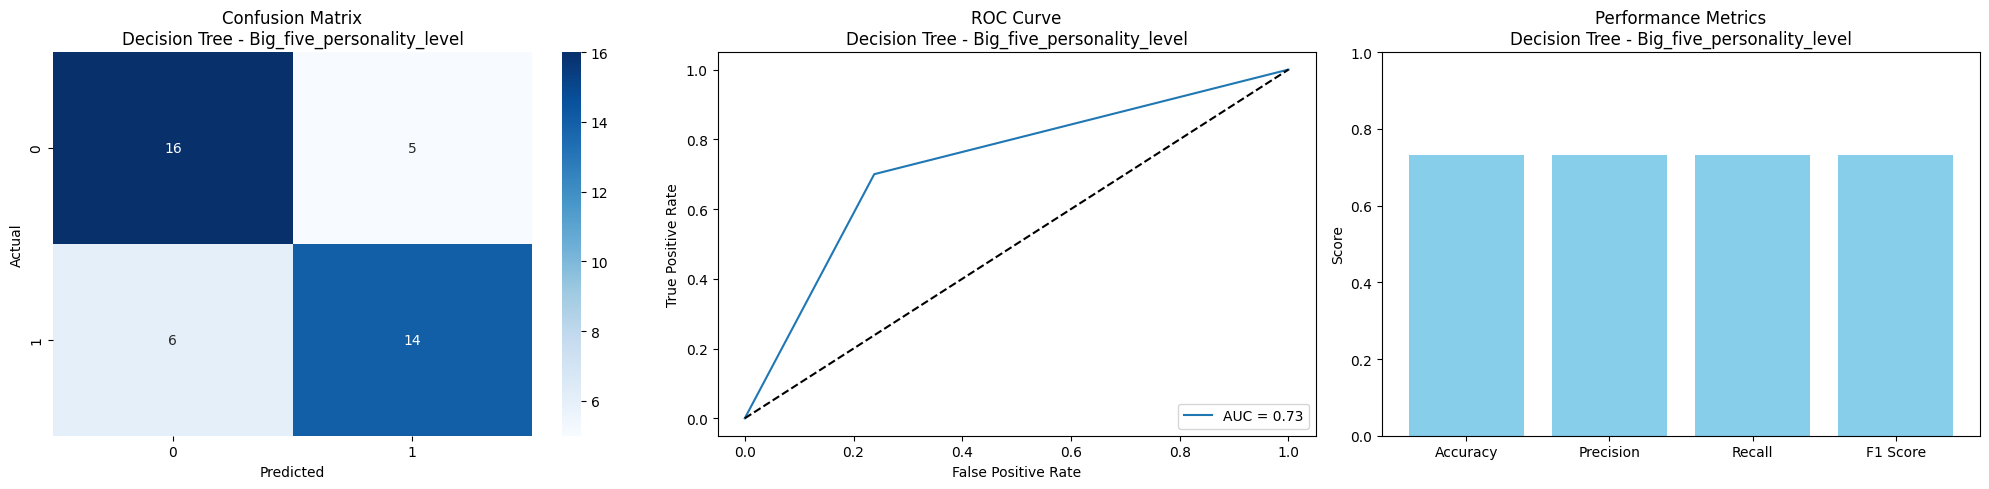

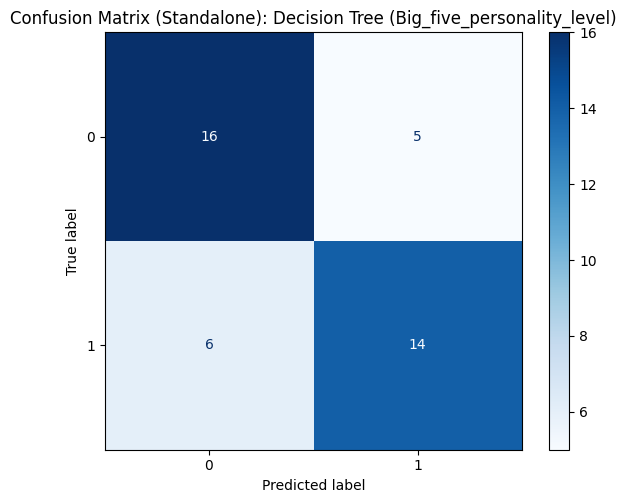


▶ Evaluating Model: SVM
  Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        21
           1       0.82      0.70      0.76        20

    accuracy                           0.78        41
   macro avg       0.79      0.78      0.78        41
weighted avg       0.79      0.78      0.78        41



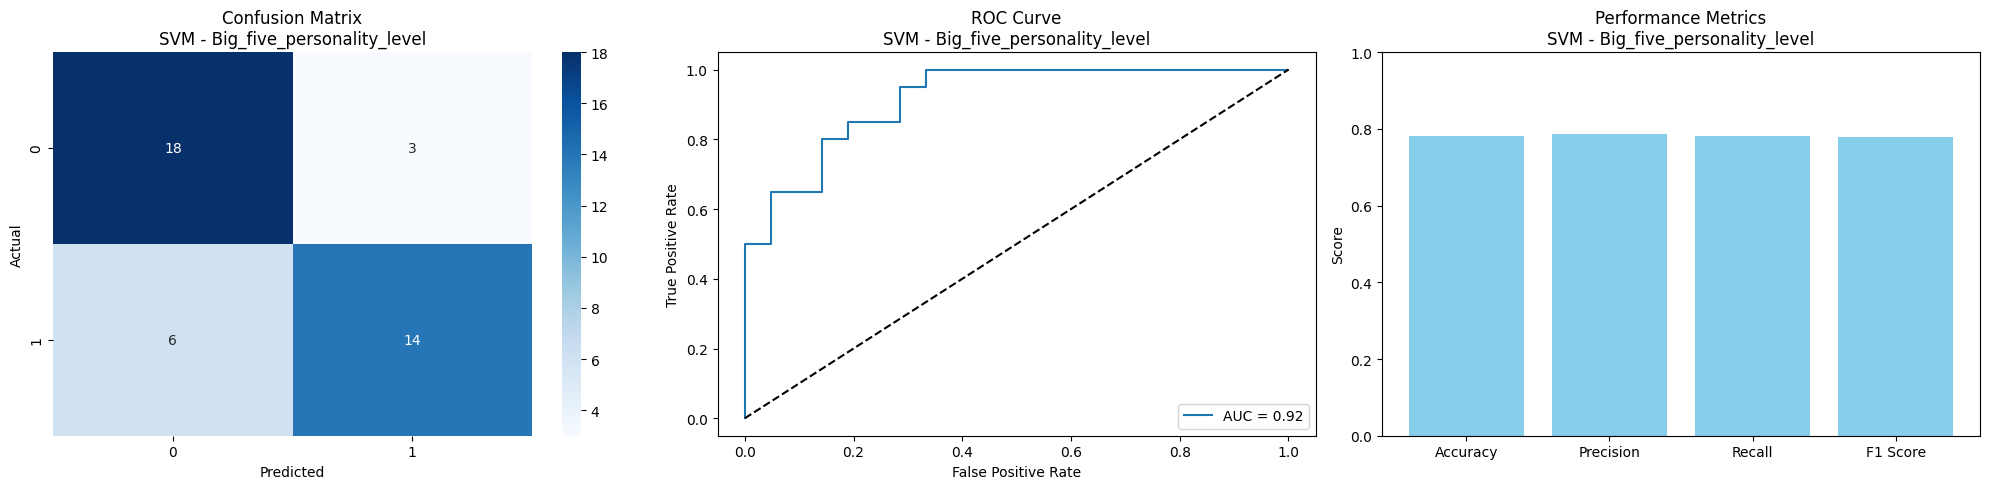

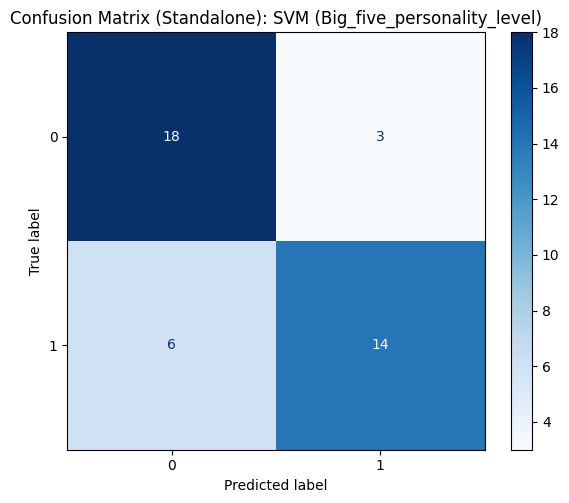


▶ Evaluating Model: Gaussian NB
  Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           1       0.72      0.65      0.68        20

    accuracy                           0.71        41
   macro avg       0.71      0.71      0.71        41
weighted avg       0.71      0.71      0.71        41



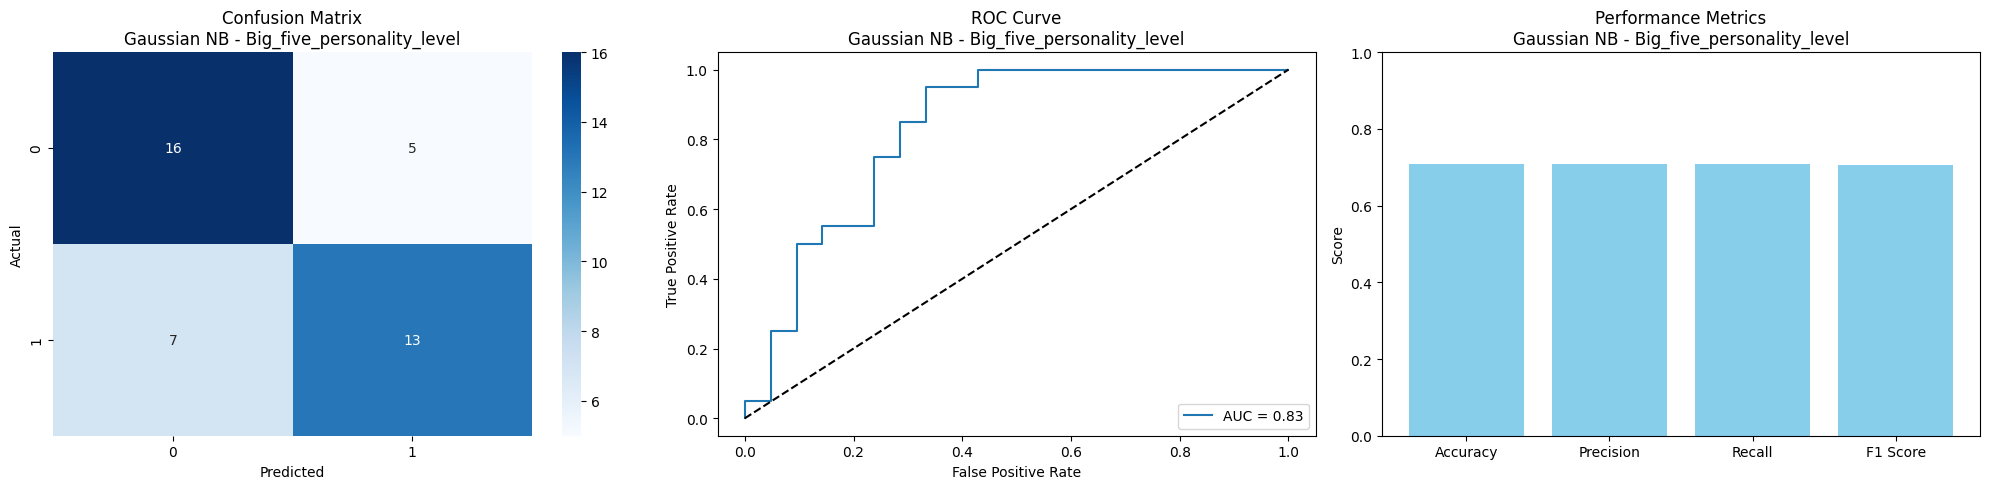

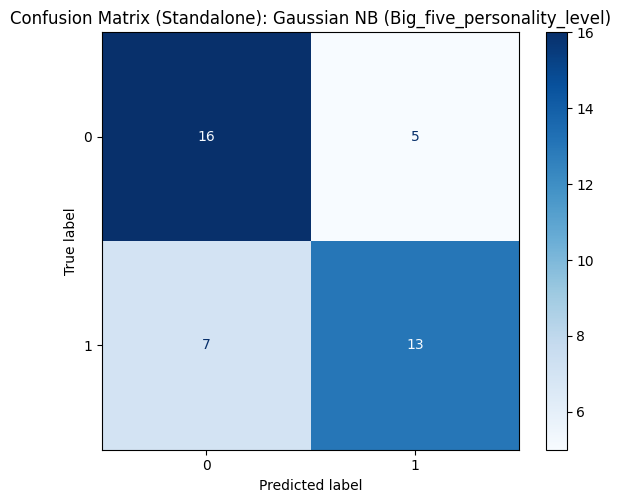


▶ Evaluating Model: Random Forest
  Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        21
           1       0.88      0.75      0.81        20

    accuracy                           0.83        41
   macro avg       0.84      0.83      0.83        41
weighted avg       0.84      0.83      0.83        41



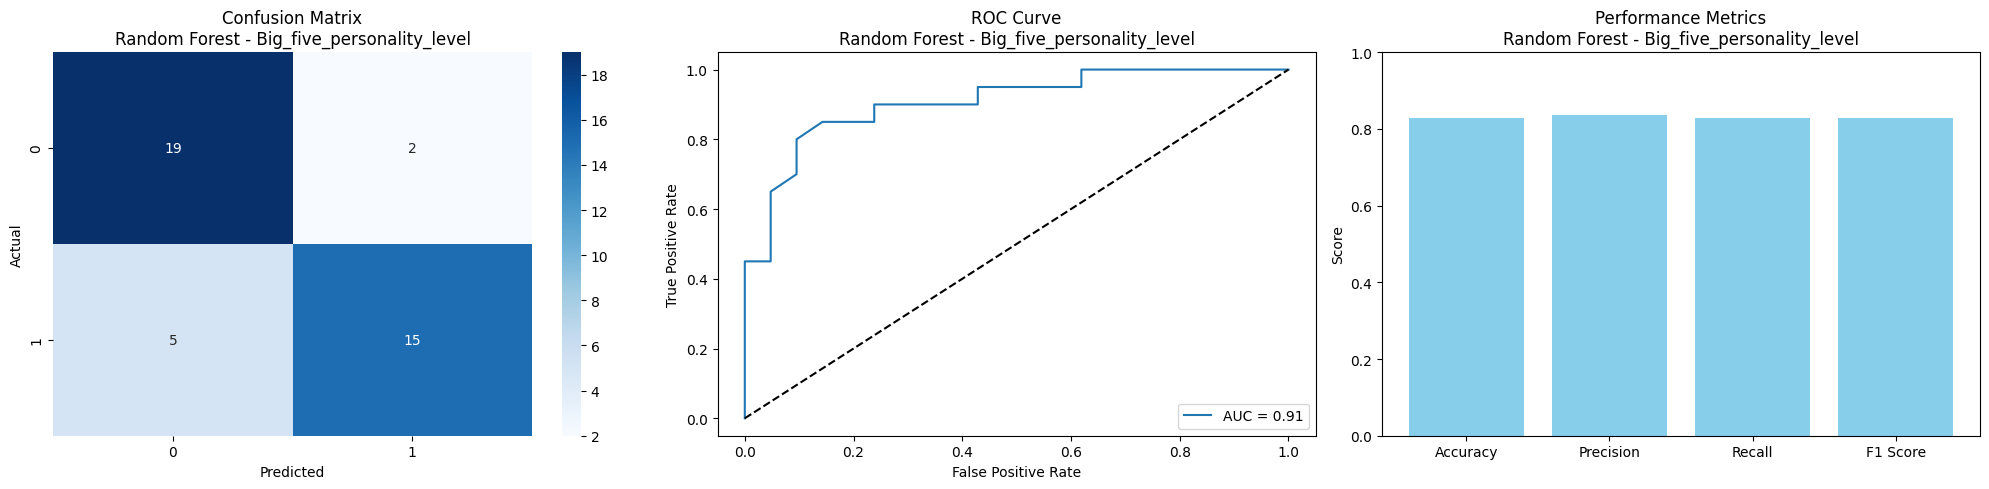

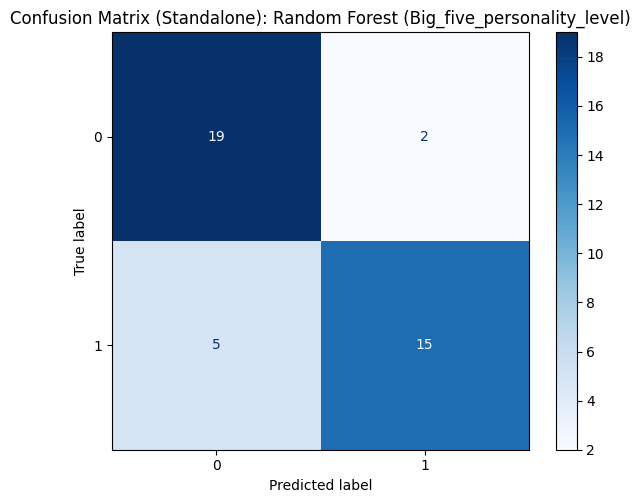


▶ Evaluating Model: Gradient Boosting
  Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        21
           1       0.94      0.75      0.83        20

    accuracy                           0.85        41
   macro avg       0.87      0.85      0.85        41
weighted avg       0.87      0.85      0.85        41



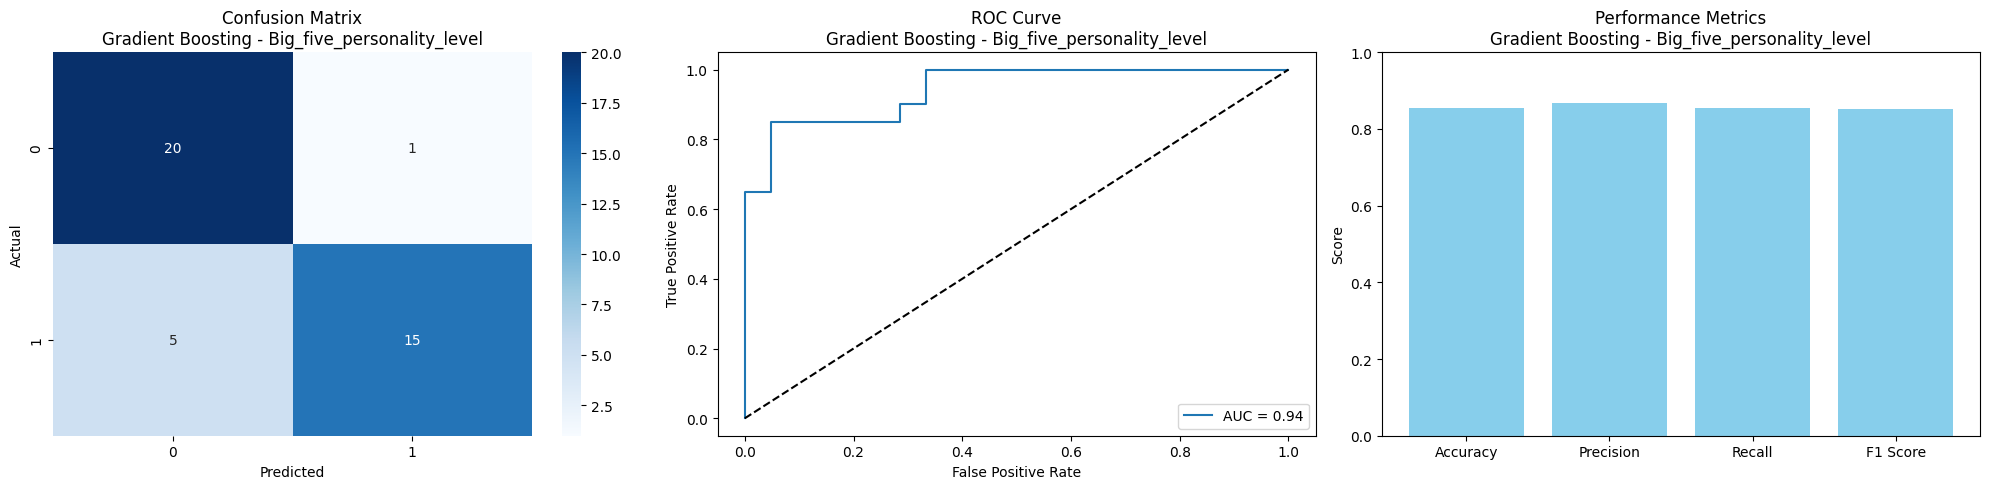

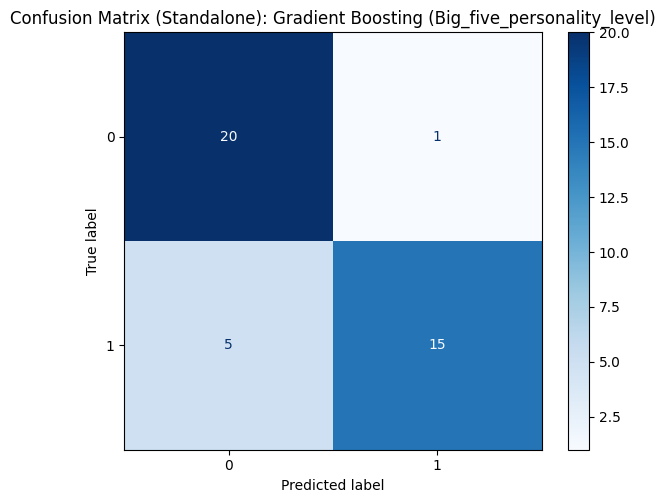


▶ Evaluating Model: XGBoost
  Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      0.70      0.82        20

    accuracy                           0.85        41
   macro avg       0.89      0.85      0.85        41
weighted avg       0.89      0.85      0.85        41



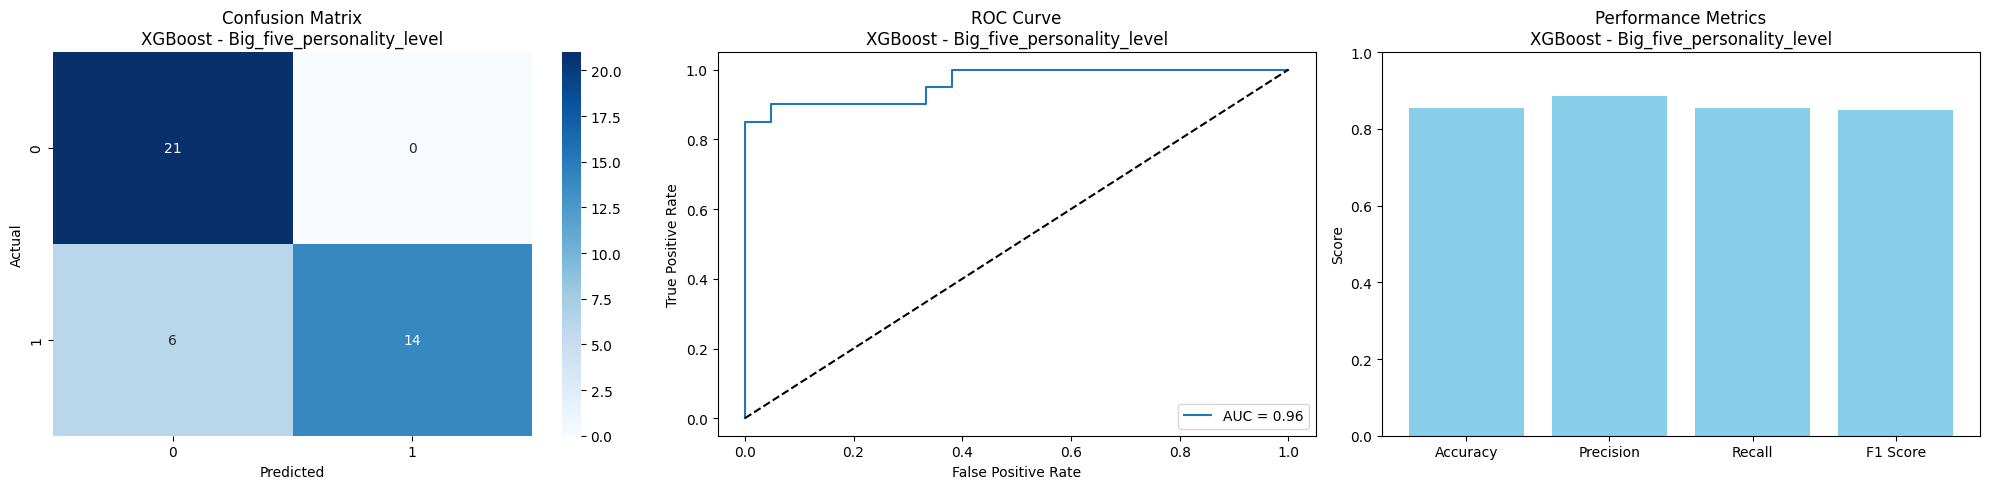

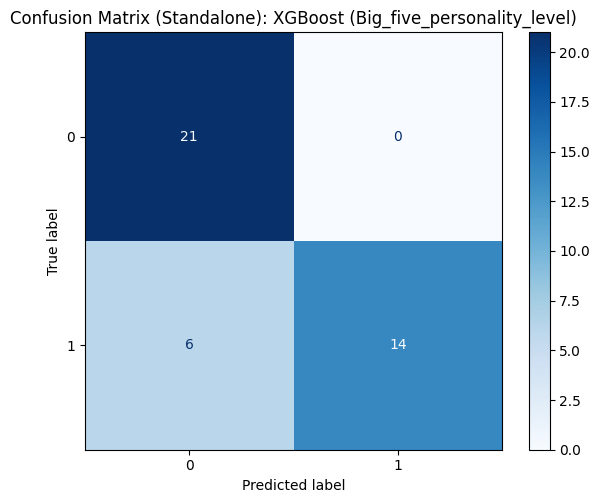


▶ Evaluating Model: Stack 1 (XGBoost + RF)
  Classification Report:
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        21
           1       1.00      0.75      0.86        20

    accuracy                           0.88        41
   macro avg       0.90      0.88      0.88        41
weighted avg       0.90      0.88      0.88        41



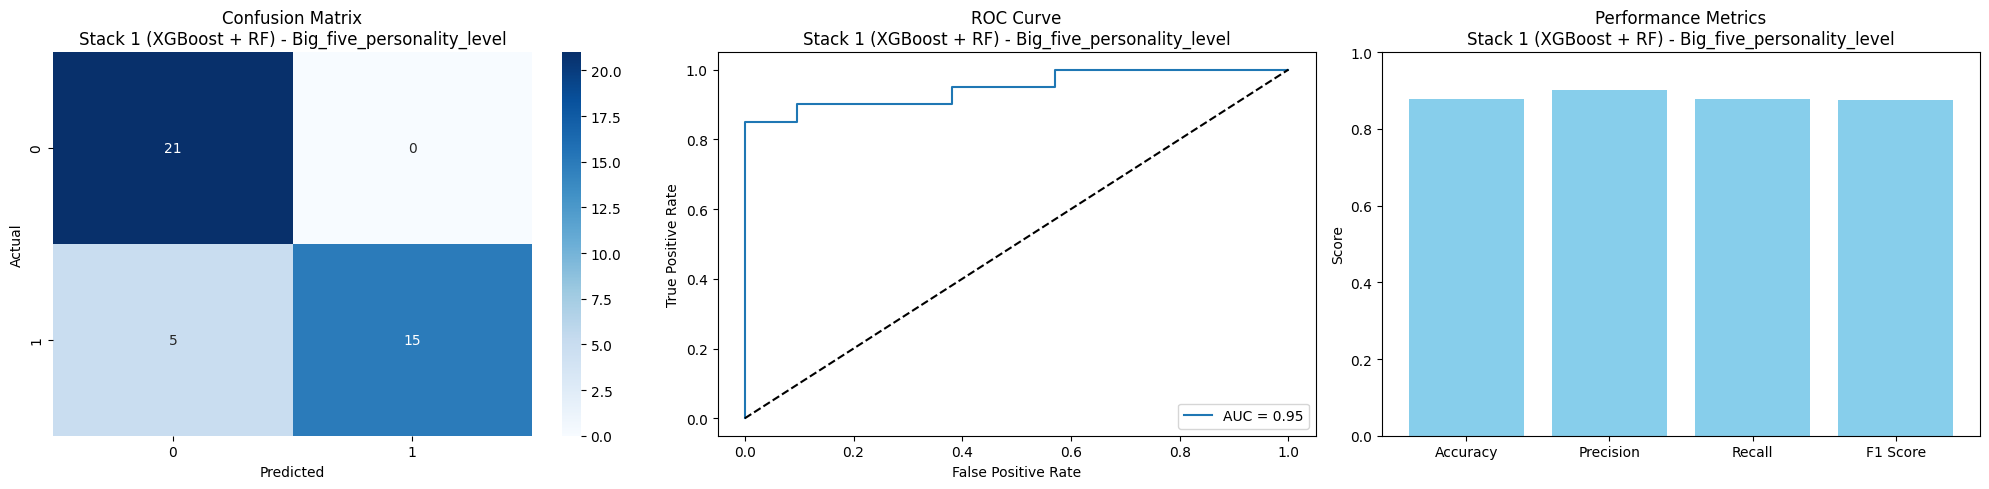

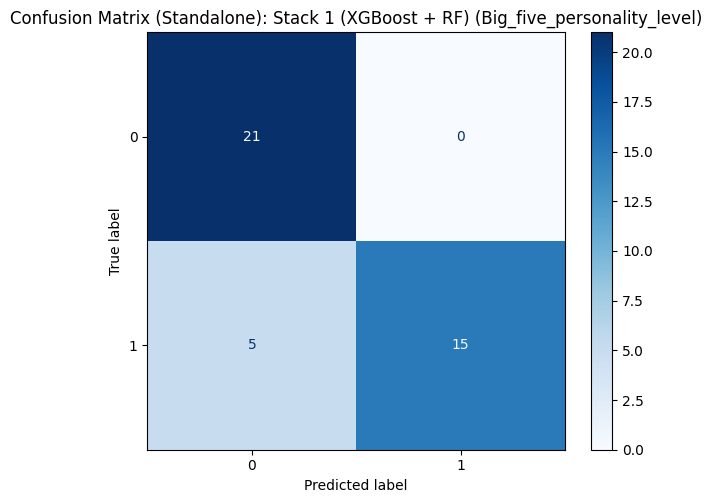


▶ Evaluating Model: Stack 2 (LogReg + GradBoost)
  Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        21
           1       0.94      0.75      0.83        20

    accuracy                           0.85        41
   macro avg       0.87      0.85      0.85        41
weighted avg       0.87      0.85      0.85        41



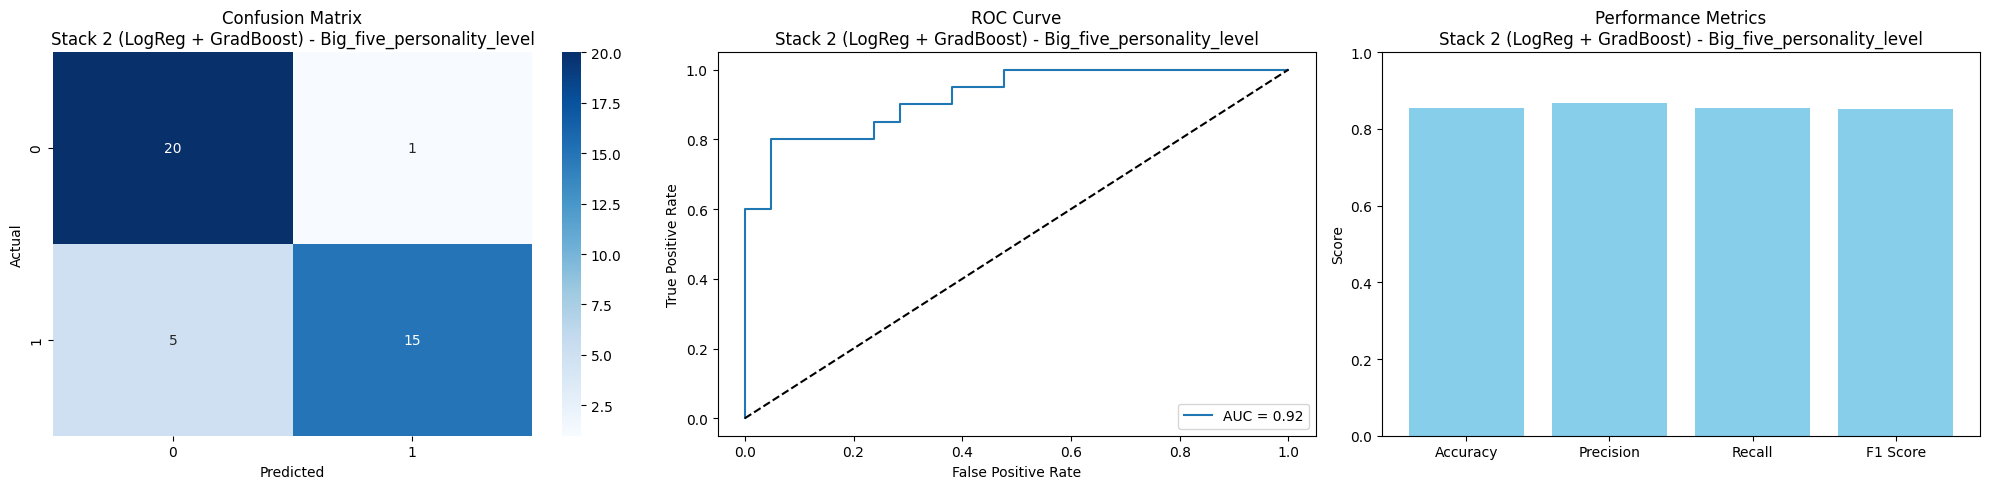

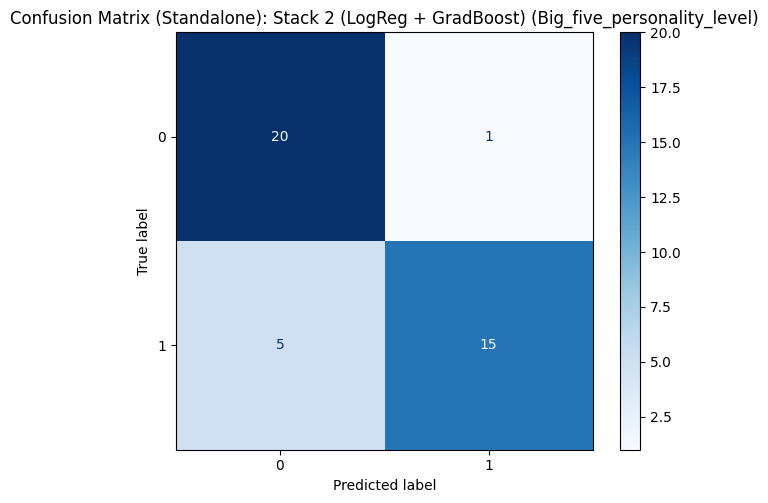


▶ Evaluating Model: Hybrid SVM+XGBoost
  Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        21
           1       1.00      0.70      0.82        20

    accuracy                           0.85        41
   macro avg       0.89      0.85      0.85        41
weighted avg       0.89      0.85      0.85        41



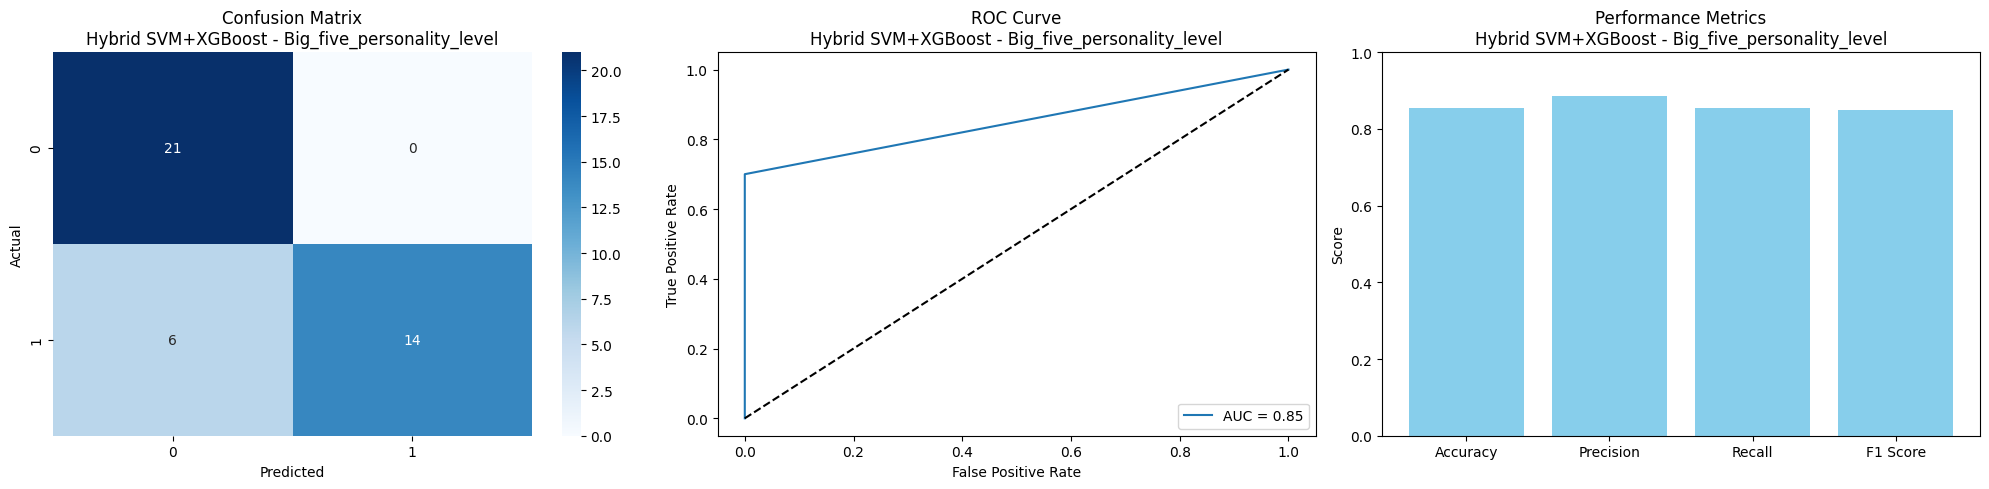

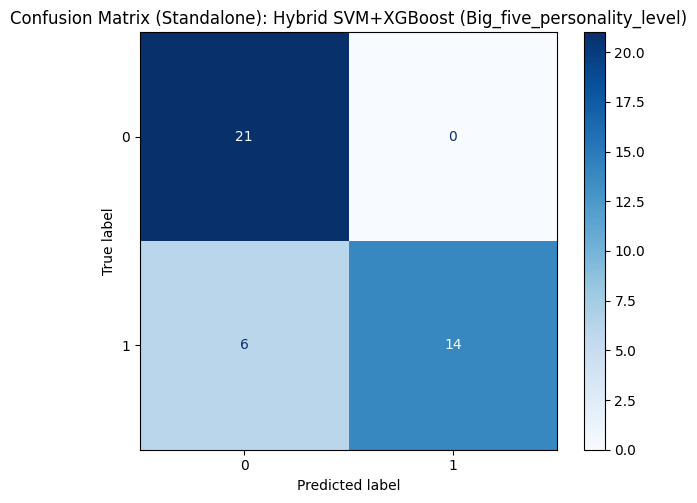


--- Metrics Summary for Target: Big_five_personality_level ---
                          Model  Accuracy  Precision    Recall  F1 Score  \
0           Logistic Regression  0.756098   0.757983  0.756098  0.755222   
1                 Decision Tree  0.731707   0.731941  0.731707  0.731387   
2                           SVM  0.780488   0.785868  0.780488  0.778906   
3                   Gaussian NB  0.707317   0.708613  0.707317  0.706267   
4                 Random Forest  0.829268   0.835904  0.829268  0.828038   
5             Gradient Boosting  0.853659   0.867073  0.853659  0.851891   
6                       XGBoost  0.853659   0.886179  0.853659  0.849892   
7        Stack 1 (XGBoost + RF)  0.878049   0.901501  0.878049  0.875825   
8  Stack 2 (LogReg + GradBoost)  0.853659   0.867073  0.853659  0.851891   
9            Hybrid SVM+XGBoost  0.853659   0.886179  0.853659  0.849892   

    ROC-AUC  
0  0.766667  
1  0.730952  
2  0.916667  
3  0.828571  
4  0.907143  
5  0.942857  
6

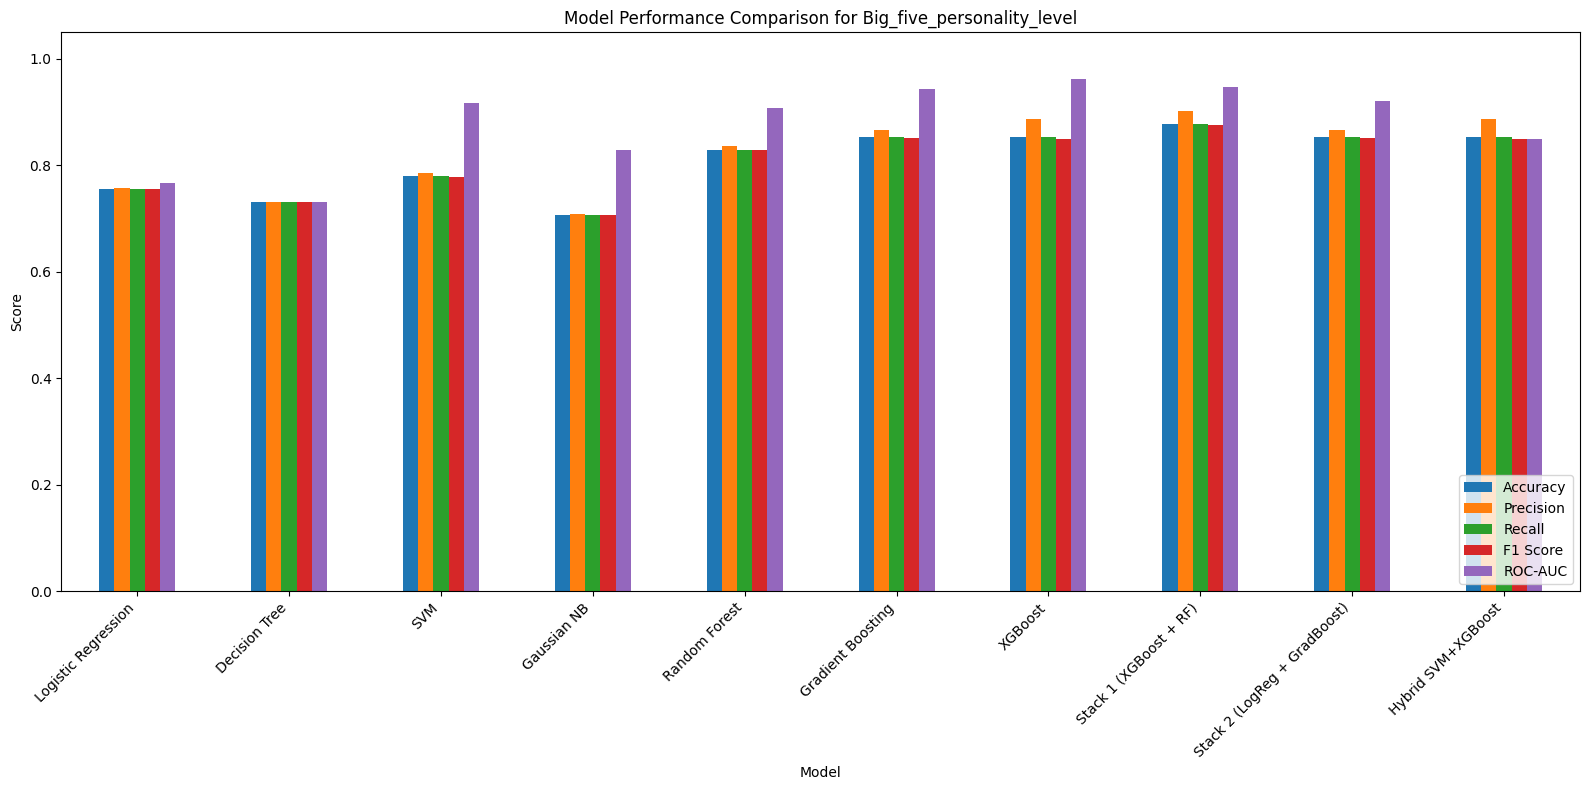


--- ML Pipeline Execution Completed ---


In [6]:
# --- Main Execution Block ---
def main():
    """
    Orchestrates the entire machine learning pipeline.
    Models are trained once per target, then evaluated.
    """
    print("--- Starting the ML Pipeline ---")

    # Step 1: Synthetic Data Generation
    synthetic_data = generate_and_save_synthetic_data(file_path='processed_data.csv', n_samples=1000) # Reduced samples for faster run if needed

    # Step 2: Data Cleaning for Synthetic Data
    cleaned_synthetic_data = clean_and_save_synthetic_data(synthetic_data)
    if cleaned_synthetic_data is None:
        print("Halting pipeline due to issues in data generation or cleaning.")
        return

    # Step 3: Data Preprocessing and Balancing (SMOTE)
    # This will create 'balanced_dataset_{target_col}.csv' files
    success_preprocess = preprocess_and_balance_data(data_path='synthetic_data_gna_cleaned.csv', target_columns=TARGET_COLUMNS)
    if not success_preprocess:
        print("Halting pipeline due to issues in preprocessing/balancing.")
        return


    # --- Centralized Training and Comprehensive Evaluation per Target ---
    for target_col in TARGET_COLUMNS:
        print(f"\n\n{'='*20} Target Variable: {target_col} {'='*20}")

        try:
            df = pd.read_csv(f"balanced_dataset_{target_col}.csv")
        except FileNotFoundError:
            print(f"Error: File 'balanced_dataset_{target_col}.csv' not found. Skipping target {target_col}.")
            continue

        X = df.drop(columns=[target_col])
        y = df[target_col]

        # Ensure y is numeric for classification if it's not already
        if not pd.api.types.is_numeric_dtype(y):
            print(f"  Target '{target_col}' is not numeric. Applying LabelEncoder.")
            le = LabelEncoder()
            y = le.fit_transform(y)
            print(f"  Encoded classes for '{target_col}': {list(le.classes_)}")


        stratify_split = y if len(np.unique(y)) >= 2 and pd.Series(y).value_counts().min() >= 2 else None
        if stratify_split is None:
             print(f"  Warning: Cannot stratify for target '{target_col}'. Using non-stratified split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=stratify_split
        )

        # --- Model Training Phase ---
        trained_models_suite = {}
        print("\n--- Training All Models ---")

        # 1. Individual Classifiers
        print("  Training Individual Models...")
        individual_defs = {
            "Logistic Regression": LogisticRegression(solver='liblinear', random_state=RANDOM_STATE),
            "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
            "SVM": SVC(probability=True, random_state=RANDOM_STATE),
            "Gaussian NB": GaussianNB(),
            "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
            "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
        }
        for name, model_instance in individual_defs.items():
            try:
                if name == "Multinomial NB" and (X_train < 0).any().any():
                    print(f"    Skipping Multinomial NB for {target_col} as features contain negative values.")
                    trained_models_suite[name] = None
                    continue
                model_instance.fit(X_train, y_train)
                trained_models_suite[name] = model_instance
                print(f"    Successfully trained {name}.")
            except Exception as e:
                print(f"    ERROR training {name} for {target_col}: {e}")
                trained_models_suite[name] = None

        # 2. Stacking Classifiers
        print("  Training Stacking Models...")
        meta_clf = LogisticRegression(random_state=RANDOM_STATE)

        # Stack 1: XGBoost + RandomForest
        if trained_models_suite.get("XGBoost") and trained_models_suite.get("Random Forest"):
            estimators_s1 = [
                ('xgb', trained_models_suite["XGBoost"]), # Cloned by StackingClassifier
                ('rf', trained_models_suite["Random Forest"]) # Cloned
            ]
            stack_1 = StackingClassifier(estimators=estimators_s1, final_estimator=meta_clf, cv=5, n_jobs=-1)
            try:
                stack_1.fit(X_train, y_train)
                trained_models_suite["Stack 1 (XGBoost + RF)"] = stack_1
                print("    Successfully trained Stack 1.")
            except Exception as e:
                print(f"    ERROR training Stack 1 for {target_col}: {e}")
                trained_models_suite["Stack 1 (XGBoost + RF)"] = None
        else:
            print("    Skipping Stack 1 due to unavailable/failed base models.")
            trained_models_suite["Stack 1 (XGBoost + RF)"] = None

        # Stack 2: Logistic Regression + Gradient Boosting
        if trained_models_suite.get("Logistic Regression") and trained_models_suite.get("Gradient Boosting"):
            estimators_s2 = [
                ('lr', trained_models_suite["Logistic Regression"]), # Cloned
                ('gb', trained_models_suite["Gradient Boosting"])   # Cloned
            ]
            stack_2 = StackingClassifier(estimators=estimators_s2, final_estimator=meta_clf, cv=5, n_jobs=-1)
            try:
                stack_2.fit(X_train, y_train)
                trained_models_suite["Stack 2 (LogReg + GradBoost)"] = stack_2
                print("    Successfully trained Stack 2.")
            except Exception as e:
                print(f"    ERROR training Stack 2 for {target_col}: {e}")
                trained_models_suite["Stack 2 (LogReg + GradBoost)"] = None
        else:
            print("    Skipping Stack 2 due to unavailable/failed base models.")
            trained_models_suite["Stack 2 (LogReg + GradBoost)"] = None

        # 3. Hybrid SVM + XGBoost
        print("  Training Hybrid SVM + XGBoost Model...")
        svm_hybrid_base = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)
        xgb_hybrid_top = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
        try:
            svm_hybrid_base.fit(X_train, y_train)
            svm_train_features = svm_hybrid_base.decision_function(X_train)
            if len(svm_train_features.shape) == 1: svm_train_features = svm_train_features.reshape(-1, 1)

            xgb_hybrid_top.fit(svm_train_features, y_train)
            trained_models_suite["Hybrid SVM+XGBoost"] = {
                'svm_extractor': svm_hybrid_base,
                'xgb_classifier': xgb_hybrid_top
            }
            print("    Successfully trained Hybrid SVM+XGBoost.")
        except Exception as e:
            print(f"    ERROR training Hybrid SVM+XGBoost for {target_col}: {e}")
            trained_models_suite["Hybrid SVM+XGBoost"] = None

        # --- Comprehensive Evaluation & Plotting Phase ---
        print(f"\n\n--- Comprehensive Evaluation & Plotting for Target: {target_col} ---")
        target_metrics_summary = []

        for model_name, model_object in trained_models_suite.items():
            if model_object is None:
                print(f"\n▶ Model: {model_name} (Skipped - Training Failed or Not Applicable)")
                target_metrics_summary.append({"Model": model_name, "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1 Score": np.nan, "ROC-AUC": np.nan})
                continue

            print(f"\n▶ Evaluating Model: {model_name}")

            y_pred_eval, y_prob_eval = None, None
            current_X_test_for_eval = X_test # Default
            final_model_for_display = model_object # Default

            try:
                if model_name == "Hybrid SVM+XGBoost":
                    svm_ext = model_object['svm_extractor']
                    xgb_class = model_object['xgb_classifier']

                    svm_test_features_eval = svm_ext.decision_function(X_test)
                    if len(svm_test_features_eval.shape) == 1: svm_test_features_eval = svm_test_features_eval.reshape(-1, 1)

                    y_pred_eval = xgb_class.predict(svm_test_features_eval)
                    # Probabilities for ROC AUC
                    if hasattr(xgb_class, "predict_proba"):
                        y_prob_eval_all_classes = xgb_class.predict_proba(svm_test_features_eval)
                        y_prob_eval = y_prob_eval_all_classes[:, 1] if len(np.unique(y_test)) == 2 and y_prob_eval_all_classes.shape[1] > 1 else y_prob_eval_all_classes

                    current_X_test_for_eval = svm_test_features_eval
                    final_model_for_display = xgb_class
                else: # Standard or other ensemble models
                    y_pred_eval = model_object.predict(X_test)
                    if hasattr(model_object, "predict_proba"):
                        y_prob_eval_all_classes = model_object.predict_proba(X_test)
                        y_prob_eval = y_prob_eval_all_classes[:, 1] if len(np.unique(y_test)) == 2 and y_prob_eval_all_classes.shape[1] > 1 else y_prob_eval_all_classes

                # Calculate Metrics
                acc = accuracy_score(y_test, y_pred_eval)
                prec = precision_score(y_test, y_pred_eval, average='weighted', zero_division=0)
                rec = recall_score(y_test, y_pred_eval, average='weighted', zero_division=0)
                f1 = f1_score(y_test, y_pred_eval, average='weighted', zero_division=0)

                roc_auc_val = np.nan
                if y_prob_eval is not None:
                    if len(np.unique(y_test)) == 2: # Binary
                         roc_auc_val = roc_auc_score(y_test, y_prob_eval) # y_prob_eval is prob of class 1
                    else: # Multiclass
                         # Ensure y_prob_eval_all_classes is a numpy array and has the correct shape
                         if isinstance(y_prob_eval_all_classes, np.ndarray) and y_prob_eval_all_classes.shape[1] == len(np.unique(y_test)):
                            roc_auc_val = roc_auc_score(y_test, y_prob_eval_all_classes, multi_class='ovr', average='weighted')
                         else:
                            print(f"    Warning: Skipping ROC-AUC for {model_name} on {target_col}. Predicted probabilities shape mismatch or not a numpy array.")


                target_metrics_summary.append({
                    "Model": model_name, "Accuracy": acc, "Precision": prec,
                    "Recall": rec, "F1 Score": f1, "ROC-AUC": roc_auc_val
                })

                print("  Classification Report:")
                print(classification_report(y_test, y_pred_eval, zero_division=0))

                # Plot comprehensive metrics (includes its own CM, ROC, and bar chart)
                plot_model_performance_metrics(y_test, y_pred_eval,
                                               y_prob_eval if len(np.unique(y_test)) == 2 else y_prob_eval_all_classes, # Pass correct prob format
                                               title=f"{model_name} - {target_col}")

                # Plot standalone confusion matrix using plot_confusion_matrix_display
                # This might be redundant if plot_model_performance_metrics already plots one, but kept per original structure.
                plot_confusion_matrix_display(final_model_for_display, current_X_test_for_eval, y_test,
                                              f'Confusion Matrix (Standalone): {model_name} ({target_col})')
            except Exception as e:
                print(f"    ERROR during evaluation/plotting for {model_name} on {target_col}: {e}")
                target_metrics_summary.append({"Model": model_name, "Accuracy": np.nan, "Precision": np.nan, "Recall": np.nan, "F1 Score": np.nan, "ROC-AUC": np.nan})

        # --- Summary Plot for the Current Target ---
        if target_metrics_summary:
            summary_df = pd.DataFrame(target_metrics_summary)
            print(f"\n--- Metrics Summary for Target: {target_col} ---")
            print(summary_df)

            summary_df.set_index("Model").plot(kind="bar", figsize=(16, 8), rot=45)
            plt.title(f"Model Performance Comparison for {target_col}")
            plt.ylabel("Score")
            plt.ylim(0, 1.05)
            plt.xticks(ha="right")
            plt.tight_layout()
            plt.legend(loc='lower right')
            plt.show()

    # Step 4 (New Flow): Decision Boundary Visualization (uses its own 2D model training)
    # visualize_decision_boundaries(TARGET_COLUMNS) # This function is not defined in the provided code

    print("\n--- ML Pipeline Execution Completed ---")

if __name__ == "__main__":
    main()